In [2]:
!pip install fuzzywuzzy rapidfuzz sentence_transformers -q

#AA

## AA partial matches

In [8]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to compute string similarity using rapidfuzz
def compute_string_similarity(text1, text2):
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    return fuzz.partial_ratio(text1, text2) / 100.0

# Function to find matches where the first word of the LSEG physical assets is the same as in my database
def find_all_first_word_matches_in_my_db(lseg_row, my_data):
    lseg_asset_name = lseg_row['Name']
    first_word_asset = lseg_asset_name.split()[0]  # Get the first word of the LSEG asset name
    matches = my_data[my_data['physical asset'].str.split().str[0] == first_word_asset]

    best_matches = []
    for _, my_row in matches.iterrows():
        best_comparison = {
            'LSEG Physical Asset': (lseg_asset_name, my_row['physical asset']),
            'Ownership': (lseg_row['Operating Company'], my_row['ownership']),
            'Commodity': (lseg_row['Commodity'], my_row['commodity']),
            'Countries': (lseg_row['Location'], my_row['Countries'])
        }
        best_matches.append(best_comparison)
    return best_matches


# Load the databases
my_database_path = '/content/AA_FINAL.csv'
lseg_database_path = '/content/AA_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match_threshold(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        best_comparison = {
            'Physical Asset': (asset_name, lseg_row['Name']),
            'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
            'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
            'Countries': (asset_row['Countries'], lseg_row['Location'])
        }
        return asset_name, lseg_row['Name'], best_comparison
    else:
        return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        print(f"Best match for '{asset_name}': '{best_match}'")
        comparisons.append(comparison)

# Evaluate the similarity metrics and compute category averages
def evaluate_similarity(comparisons):
    metrics = []
    category_averages = {
        'Physical Asset': [],
        'Ownership': [],
        'Commodity': [],
        'Countries': []
    }
    for comp in comparisons:
        similarity_scores = {}
        for key in category_averages.keys():
            my_val, lseg_val = comp[key]
            similarity = compute_string_similarity(my_val, lseg_val)
            similarity_scores[key] = similarity
            category_averages[key].append(similarity)
        metrics.append(similarity_scores)
    return metrics, category_averages

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    average_score = np.mean(valid_scores) if valid_scores else None
    print(f"{category} Average Score: {average_score:.2f}")



Best match for 'pocos de caldas mine': 'pocos de caldas'
Best match for 'juruti mine': 'juruti'
Best match for 'huntly mine': 'huntly'
Best match for 'juruti bauxite mine': 'juruti'
Best match for 'land and mines': 'sandow coal mine'
Best match for 'willowdale mine': 'willowdale'
Best match for 'huntly and willowdale bauxite mines': 'huntly'
Physical Asset Average Score: 0.95
Ownership Average Score: 0.93
Commodity Average Score: 0.52
Countries Average Score: 1.00


<ipython-input-8-fc2661914e72>:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-8-fc2661914e72>:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


In [ ]:
!pip install tensorflow tensorflow-ranking -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.3 MB/s eta 0:00:00


## AA hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/AA_FINAL.csv'
lseg_database_path = '/content/AA_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.714286
Ownership              0.714286
Commodity              0.714286
Countries              0.714286
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: huntly
My Database Entry: huntly
Ownership: alcoa corp -> alcoa corporation
Commodity: aluminium / primary aluminium -> bauxite
Countries: australia -> australia
--------------------------------------------------
LSEG Database Entry: huntly
My Database Entry: huntly and willowdale bauxite mines
Ownership: alcoa corp -> alcoa corporation,alumina limited,awac,mbac
Commodity: aluminium / primary aluminium -> bauxite,alumina,aluminum
Countries: australia -> australia,brazil,guinea,spain,saudi arabia,canada
--------------------------------------------------
LSEG Database Entry: pocos de caldas
My Database Entry: pocos de caldas
Ownership: alcoa corp -> alcoa corporation,alumina limited
Commodity: aluminium / primary aluminium -> bauxite
Countries: brazil -> brazil
-----------------

<ipython-input-4-be57966a471a>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-4-be57966a471a>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


#AA other metrics

In [18]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Function to compute Jaccard similarity
def compute_jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Function to compute Cosine similarity
def compute_cosine_similarity(text1, text2):
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    vectorizer = CountVectorizer().fit_transform([str(text1), str(text2)])
    vectors = vectorizer.toarray()
    return 1 - cosine(vectors[0], vectors[1])

# Function to compute Dice similarity coefficient
def compute_dice_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))

# Function to compute Normalized Levenshtein similarity
def compute_normalized_levenshtein_similarity(text1, text2):
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    lev_distance = levenshtein_distance(str(text1), str(text2))
    max_len = max(len(str(text1)), len(str(text2)))
    return 1 - (lev_distance / max_len)

# Load the databases
my_database_path = '/content/AA_FINAL.csv'
lseg_database_path = '/content/AA_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Evaluate the similarity metrics for matched physical assets and return averages
def evaluate_similarity_all(comparisons):
    # Initialize sums and counts for averaging
    sums = {
        'Physical Asset Jaccard': 0,
        'Physical Asset Cosine': 0,
        'Physical Asset Dice': 0,
        'Physical Asset Levenshtein': 0,
        'Ownership Jaccard': 0,
        'Ownership Cosine': 0,
        'Ownership Dice': 0,
        'Ownership Levenshtein': 0,
        'Commodity Jaccard': 0,
        'Commodity Cosine': 0,
        'Commodity Dice': 0,
        'Commodity Levenshtein': 0,
        'Countries Jaccard': 0,
        'Countries Cosine': 0,
        'Countries Dice': 0,
        'Countries Levenshtein': 0
    }
    counts = {key: 0 for key in sums.keys()}

    for comp in comparisons:
        # Physical Asset Jaccard
        set1 = set(str(comp['Physical Asset'][0]).split())
        set2 = set(str(comp['Physical Asset'][1]).split())
        jaccard_score = compute_jaccard_similarity(set1, set2)
        sums['Physical Asset Jaccard'] += jaccard_score
        counts['Physical Asset Jaccard'] += 1

        # Physical Asset Cosine
        cosine_score = compute_cosine_similarity(comp['Physical Asset'][0], comp['Physical Asset'][1])
        if not np.isnan(cosine_score):
            sums['Physical Asset Cosine'] += cosine_score
            counts['Physical Asset Cosine'] += 1

        # Physical Asset Dice
        dice_score = compute_dice_similarity(set1, set2)
        sums['Physical Asset Dice'] += dice_score
        counts['Physical Asset Dice'] += 1

        # Physical Asset Levenshtein
        levenshtein_score = compute_normalized_levenshtein_similarity(comp['Physical Asset'][0], comp['Physical Asset'][1])
        if not np.isnan(levenshtein_score):
            sums['Physical Asset Levenshtein'] += levenshtein_score
            counts['Physical Asset Levenshtein'] += 1

        # Ownership Jaccard
        set1 = set(str(comp['Ownership'][0]).split())
        set2 = set(str(comp['Ownership'][1]).split())
        jaccard_score = compute_jaccard_similarity(set1, set2)
        sums['Ownership Jaccard'] += jaccard_score
        counts['Ownership Jaccard'] += 1

        # Ownership Cosine
        cosine_score = compute_cosine_similarity(comp['Ownership'][0], comp['Ownership'][1])
        if not np.isnan(cosine_score):
            sums['Ownership Cosine'] += cosine_score
            counts['Ownership Cosine'] += 1

        # Ownership Dice
        dice_score = compute_dice_similarity(set1, set2)
        sums['Ownership Dice'] += dice_score
        counts['Ownership Dice'] += 1

        # Ownership Levenshtein
        levenshtein_score = compute_normalized_levenshtein_similarity(comp['Ownership'][0], comp['Ownership'][1])
        if not np.isnan(levenshtein_score):
            sums['Ownership Levenshtein'] += levenshtein_score
            counts['Ownership Levenshtein'] += 1

        # Commodity Jaccard
        set1 = set(str(comp['Commodity'][0]).split())
        set2 = set(str(comp['Commodity'][1]).split())
        jaccard_score = compute_jaccard_similarity(set1, set2)
        sums['Commodity Jaccard'] += jaccard_score
        counts['Commodity Jaccard'] += 1

        # Commodity Cosine
        cosine_score = compute_cosine_similarity(comp['Commodity'][0], comp['Commodity'][1])
        if not np.isnan(cosine_score):
            sums['Commodity Cosine'] += cosine_score
            counts['Commodity Cosine'] += 1

        # Commodity Dice
        dice_score = compute_dice_similarity(set1, set2)
        sums['Commodity Dice'] += dice_score
        counts['Commodity Dice'] += 1

        # Commodity Levenshtein
        levenshtein_score = compute_normalized_levenshtein_similarity(comp['Commodity'][0], comp['Commodity'][1])
        if not np.isnan(levenshtein_score):
            sums['Commodity Levenshtein'] += levenshtein_score
            counts['Commodity Levenshtein'] += 1

        # Countries Jaccard
        set1 = set(str(comp['Countries'][0]).split())
        set2 = set(str(comp['Countries'][1]).split())
        jaccard_score = compute_jaccard_similarity(set1, set2)
        sums['Countries Jaccard'] += jaccard_score
        counts['Countries Jaccard'] += 1

        # Countries Cosine
        cosine_score = compute_cosine_similarity(comp['Countries'][0], comp['Countries'][1])
        if not np.isnan(cosine_score):
            sums['Countries Cosine'] += cosine_score
            counts['Countries Cosine'] += 1

        # Countries Dice
        dice_score = compute_dice_similarity(set1, set2)
        sums['Countries Dice'] += dice_score
        counts['Countries Dice'] += 1

        # Countries Levenshtein
        levenshtein_score = compute_normalized_levenshtein_similarity(comp['Countries'][0], comp['Countries'][1])
        if not np.isnan(levenshtein_score):
            sums['Countries Levenshtein'] += levenshtein_score
            counts['Countries Levenshtein'] += 1

    # Calculate averages
    averages = {key: sums[key] / counts[key] if counts[key] > 0 else np.nan for key in sums.keys()}

    return averages

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.7833
Physical Asset Cosine: 0.8591
Physical Asset Dice: 0.8333
Physical Asset Levenshtein: 0.7667
Ownership Jaccard: 0.2139
Ownership Cosine: 0.3609
Ownership Dice: 0.3389
Ownership Levenshtein: 0.3658
Commodity Jaccard: 0.0000
Commodity Cosine: 0.0000
Commodity Dice: 0.0000
Commodity Levenshtein: 0.1839
Countries Jaccard: 0.8333
Countries Cosine: 0.8963
Countries Dice: 0.8333
Countries Levenshtein: 0.8639

Matches Made with All Entities:
My Database Entry: pocos de caldas
LSEG Database Entry: pocos de caldas
Ownership: alcoa corporation,alumina limited -> alcoa corp
Commodity: bauxite -> aluminium / primary aluminium
Countries: brazil -> brazil
--------------------------------------------------
My Database Entry: juruti
LSEG Database Entry: juruti
Ownership: alcoa corporation,alumina limited -> alcoa corp
Commodity: bauxite -> aluminium / primary aluminium
Countries: brazil -> brazil
------------------------------------------------

<ipython-input-18-31eca3444ec5>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-18-31eca3444ec5>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#AA validation coverage

# validation with just LSEG database

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/AA_FINAL.csv'
df = pd.read_csv(file_path)

physical_assets_list = ["huntly", "huntly and willowdale bauxite mines", "pocos de caldas", "pocos de caldas smelter", "juruti", "juruti bauxite", "willowdale", "jarrahdale mining center","sandow coal mine"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")



Total entries in CSV: 115
Total matches: 8
Percentage of matches: 6.96%


## validation with both LSEG and RAG

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/AA_FINAL.csv'
df = pd.read_csv(file_path)

physical_assets_list = ["huntly", "huntly and willowdale bauxite mines", "pocos de caldas", "pocos de caldas smelter", "juruti", "juruti bauxite", "willowdale", "jarrahdale mining center"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")



Total entries in CSV: 115
Total matches: 8
Percentage of matches: 6.96%


## AA coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/AA_FINAL.csv'
lseg_database_path = '/content/AA_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines or mining and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains(r'\bmine\b|\bmining\b|\bcomplex\b|\bfacilities\b|\bmines\b|\boperations\b', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out physical assets from my database
print("My physical assets (mines or mining):")
print(mine_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Function to find best match and track coverage based on the first word
def find_best_match_with_coverage(asset_row, lseg_data):
    asset_name = asset_row['physical asset']
    asset_first_word = get_first_word(asset_name)

    best_match = None
    best_score = -1
    matches = []

    for lseg_name in lseg_data['Name']:
        if get_first_word(lseg_name) == asset_first_word:
            score = compute_string_similarity(asset_name, lseg_name)
            matches.append((lseg_name, score))
            if score > best_score:
                best_match = lseg_name
                best_score = score

    if best_match:
        return asset_name, best_match, matches, True
    else:
        return asset_name, None, matches, False

# Compare mine entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in mine_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets (mines or mining):
['facilities' 'aluminum facilities in avila and a coruã\x83â±a'
 'pocos de caldas mine' 'darling range mine' 'juruti mine'
 'bauxite mine and alumina refinery' 'huntly mine' 'juruti bauxite mine'
 'land and mines' 'mines' 'mining areas' 'mining operations'
 'open-cut mines' 'tailing facilities' 'warrick operations'
 'willowdale mine' 'aluminum smelting and casting facilities'
 'mine and refinery  in suriname' 'huntly and willowdale bauxite mines'
 'jarrahdale mining center' 'myara north  mine' 'holyoake  mine'
 'residue storage facilities' 'portfolio of energy facilities'
 'aluminum manufacturing facilities' 'brazilian hydroelectric facilities'
 'la coruna aluminum facilities' 'coal mine' 'office facilities'
 "alcoa's darling range mining operations" 'mining areas and refineries']

LSEG physical assets:
['huntly' 'pocos de caldas' 'juruti' 'willowdale' 'jarrahdale'
 'anglesea coal mine' 'sandow coal mine']

Number of physical assets in my database 

<ipython-input-8-2259ada307ae>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-8-2259ada307ae>:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#SCCO

In [9]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/SCCO_FINAL.csv'
lseg_database_path = '/content/SCCO_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        print(f"Best match for '{asset_name}': '{best_match}'")
        comparisons.append(comparison)

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    average_score = np.mean(valid_scores) if valid_scores else None
    print(f"{category} Average Score: {average_score:.2f}")



Best match for 'buena tierra mine': 'buenavista (cananea)'
Best match for 'la caridad mine': 'la caridad mine'
Best match for 'taxco mine': 'taxco'
Best match for 'el salado (montonero) mine': 'el arco'
Physical Asset Average Score: 0.81
Ownership Average Score: 1.00
Commodity Average Score: 0.68
Countries Average Score: 0.82


<ipython-input-9-654d26c8aea7>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-9-654d26c8aea7>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## SCCO hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/SCCO_FINAL.csv'
lseg_database_path = '/content/SCCO_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)



# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.545455
Ownership              0.545455
Commodity              0.545455
Countries              0.545455
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: buenavista (cananea)
My Database Entry: buenavista mining complex
Ownership: southern copper corp -> southern copper corporation
Commodity: molybdenum, silver, copper,zinc -> copper,silver,zinc,molybdenum
Countries: mexico -> mexico
--------------------------------------------------
LSEG Database Entry: buenavista (cananea)
My Database Entry: buenavista cu plant
Ownership: southern copper corp -> nan
Commodity: molybdenum, silver, copper,zinc -> copper
Countries: mexico -> mexico
--------------------------------------------------
LSEG Database Entry: buenavista (cananea)
My Database Entry: buenavista new tailings dam
Ownership: southern copper corp -> southern copper corporation,scc's peruvian branch,buenavista del cobre s.a. de c.v.
Commodity: molybdenum, silver, copper,zinc 

<ipython-input-5-cd6996fc55f2>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-5-cd6996fc55f2>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


#SCCO other metrics

In [15]:
!pip install pandas -q
!pip install numpy -q
!pip install rapidfuzz -q
!pip install scikit-learn -q
!pip install python-Levenshtein -q
!pip install scipy -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/SCCO_FINAL.csv'
lseg_database_path = '/content/SCCO_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison



# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.6389
Physical Asset Cosine: 0.7416
Physical Asset Dice: 0.7333
Physical Asset Levenshtein: 0.6349
Ownership Jaccard: 0.3000
Ownership Cosine: 0.5375
Ownership Dice: 0.4127
Ownership Levenshtein: 0.5590
Commodity Jaccard: 0.0000
Commodity Cosine: 0.5244
Commodity Dice: 0.0000
Commodity Levenshtein: 0.1966
Countries Jaccard: 0.6667
Countries Cosine: 0.6667
Countries Dice: 0.6667
Countries Levenshtein: 0.7222

Matches Made with All Entities:
My Database Entry: la caridad
LSEG Database Entry: la caridad mine
Ownership: southern copper corporation,immsa,minera mexico,sx-ew -> southern copper corp
Commodity: copper,silver,zinc,molybdenum -> molybdenum, copper, silver
Countries: mexico -> mexico
--------------------------------------------------
My Database Entry: taxco
LSEG Database Entry: taxco
Ownership: southern copper corporation -> southern copper corp
Commodity: copper,minerals -> zinc
Countries: mexico -> mexico
-------------------

<ipython-input-55-c4c78974b669>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-55-c4c78974b669>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# SCCO validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/SCCO_FINAL.csv'
df = pd.read_csv(file_path)

# list of physical assets
physical_assets_list = ["la caridad", "taxco", "el salado (montonero)", "buenavista mining complex", "buenavista cu plant", "buenavista new tailings dam",
                        "buenavista mining complex", "buenavista zinc (bvz) pit area", "la tapada deposit", "la hoyada prospect", "la chilena prospect", "la angostura dam",
                        "el arco mill", "el pilar", "el salado (montonero)", "michiquillay copper project", "pilares"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 220
Total matches: 16
Percentage of matches: 7.27%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/SCCO_FINAL.csv'
df = pd.read_csv(file_path)

# list of physical assets
physical_assets_list = [
    "buenavista mining complex", "buenavista cu plant", "buenavista new tailings dam",
    "buenavista mining complex", "buenavista zinc (bvz) pit area", "la caridad",
    "la tapada deposit", "la hoyada prospect", "la chilena prospect",
    "la angostura dam", "el arco mill", "el pilar", "el salado (montonero)",
    "michiquillay copper project", "taxco", "pilares"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 220
Total matches: 16
Percentage of matches: 7.27%


## SCCO coverage before table parsing


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/SCCO_FINAL.csv'
lseg_database_path = '/content/SCCO_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['facilities' 'mining concessions' 'concentrator' 'cuajone mine'
 'el arco mill' 'facilities (mining,smelting,refining)' 'toquepala mine'
 'a water storage dam and reservoir' 'zinc refinery' 'acid plant'
 'administration building' 'anode furnace' 'anode washing facility'
 'ball mills' 'berms' 'blister plant' 'boilers' 'buena tierra mine'
 'buenavista mining complex' 'buenavista cu plant'
 'buenavista new tailings dam' 'by-product plant'
 'calcine processing area' 'callazas dam' 'casting wheels'
 'cathode stripping machines' 'coal washing plant' 'concentrators'
 'converters' 'copper leaching process equipment' 'crushing circuit'
 'cularjahuira dam' 'dams' 'diamond drilling program'
 'diamond exploration tools' 'dore casting system' 'drilling equipment'
 'effluent and dust treatment plant' 'el pilar' 'electrical substations'
 'electrolytic copper refinery' 'electrolytic extraction tanks'
 'exploration and exploitation of copper and other metal reserves'
 'exploration 

<ipython-input-24-519111f13b5a>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-24-519111f13b5a>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## SCCO coverage after table parsing

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/SCCO_FINAL.csv'
file2 = '/content/SCCO_tables_output.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('SCCO_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/SCCO_w_table_coverage.csv'
lseg_database_path = '/content/SCCO_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['facilities' 'mining concessions' 'concentrator' 'cuajone mine'
 'el arco mill' 'facilities (mining,smelting,refining)' 'toquepala mine'
 'a water storage dam and reservoir' 'zinc refinery' 'acid plant'
 'administration building' 'anode furnace' 'anode washing facility'
 'ball mills' 'berms' 'blister plant' 'boilers' 'buena tierra mine'
 'buenavista mining complex' 'buenavista cu plant'
 'buenavista new tailings dam' 'by-product plant'
 'calcine processing area' 'callazas dam' 'casting wheels'
 'cathode stripping machines' 'coal washing plant' 'concentrators'
 'converters' 'copper leaching process equipment' 'crushing circuit'
 'cularjahuira dam' 'dams' 'diamond drilling program'
 'diamond exploration tools' 'dore casting system' 'drilling equipment'
 'effluent and dust treatment plant' 'el pilar' 'electrical substations'
 'electrolytic copper refinery' 'electrolytic extraction tanks'
 'exploration and exploitation of copper and other metal reserves'
 'exploration 

<ipython-input-27-80ef1edc9550>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-27-80ef1edc9550>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#FCX

In [10]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/FCX_FINAL.csv'
lseg_database_path = '/content/FCX_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        print(f"Best match for '{asset_name}': '{best_match}'")
        comparisons.append(comparison)

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    average_score = np.mean(valid_scores) if valid_scores else None
    print(f"{category} Average Score: {average_score:.2f}")



Best match for 'grasberg minerals district': 'grasberg'
Best match for 'ajo mine': 'ajo (new cornelia) copper mine'
Best match for 'baghdad mine': 'bagdad'
Best match for 'cerro verde mine': 'cerro verde copper (sx-ew) mine'
Best match for 'chino mine': 'chino copper (sx-ew) mine'
Best match for 'el abra mine': 'el abra sulphides'
Best match for 'grasberg mine': 'grasberg'
Best match for 'grasberg mine': 'grasberg'
Best match for 'kucing liar mine': 'kucing liar'
Best match for 'morenci mine': 'morenci copper (sx-ew) mine'
Physical Asset Average Score: 0.88
Ownership Average Score: 0.93
Commodity Average Score: 0.87
Countries Average Score: 1.00


<ipython-input-10-834f69401327>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-10-834f69401327>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## FCX hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/FCX_FINAL.csv'
lseg_database_path = '/content/FCX_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.846154
Ownership              0.846154
Commodity              0.769231
Countries              0.846154
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: sierrita
My Database Entry: sierrita mining complex
Ownership: freeport-mcmoran inc -> freeport-mcmoran,pt freeport indonesia
Commodity: copper -> copper,gold,molybdenum,silver
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: sierrita
My Database Entry: sierrita and miami facilities in arizona
Ownership: freeport-mcmoran inc -> freeport-mcmoran
Commodity: copper -> copper,copper concentrate
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: kucing liar
My Database Entry: kucing liar
Ownership: freeport indonesia pt -> freeport-mcmoran,pt freeport indonesia
Commodity: gold -> copper,gold,molybdenum,silver
Countries: indonesia -> indonesia
--------------------------------------------------
LS

<ipython-input-7-f890efa51f8c>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-7-f890efa51f8c>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


#FCX other metrics

In [21]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/FCX_FINAL.csv'
lseg_database_path = '/content/FCX_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison


# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.5667
Physical Asset Cosine: 0.7014
Physical Asset Dice: 0.6672
Physical Asset Levenshtein: 0.5148
Ownership Jaccard: 0.1667
Ownership Cosine: 0.7063
Ownership Dice: 0.2222
Ownership Levenshtein: 0.5020
Commodity Jaccard: 0.0000
Commodity Cosine: 0.3668
Commodity Dice: 0.0000
Commodity Levenshtein: 0.2114
Countries Jaccard: 1.0000
Countries Cosine: 1.0000
Countries Dice: 1.0000
Countries Levenshtein: 1.0000

Matches Made with All Entities:
My Database Entry: grasberg minerals district
LSEG Database Entry: grasberg
Ownership: pt freeport indonesia,freeport-mcmoran,mind id -> freeport-mcmoran inc
Commodity: minerals,copper,gold,molybdenum,silver -> silver
Countries: indonesia -> indonesia
--------------------------------------------------
My Database Entry: ajo
LSEG Database Entry: ajo (new cornelia) copper mine
Ownership: freeport-mcmoran -> freeport-mcmoran inc
Commodity: copper -> molybdenum
Countries: usa -> usa
-------------------

<ipython-input-21-8c31532fb130>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-21-8c31532fb130>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# FCX validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/FCX_FINAL.csv'
df = pd.read_csv(file_path)

# Combined list of physical assets including the new list
physical_assets_list = ["grasberg minerals district", "ajo", "cerro verde", "chino", "el abra", "grasberg", "kucing liar", "morenci", "grasberg minerals district", "el abra"]



# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 136
Total matches: 10
Percentage of matches: 7.35%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/FCX_FINAL.csv'
df = pd.read_csv(file_path)

# Combined list of physical assets including the new list
physical_assets_list = [
    "grasberg minerals district", "ajo", "sierrita mining complex",
    "sierrita and miami facilities in arizona", "kucing liar", "morenci",
    "grasberg", "el abra", "el paso refinery", "cerro verde",
    "cerro verde", "chino", "chino", "Greenfield Smelter",
    "Atlantic Copper Facility Ajo Mine", "Bagdad Mine", "Big Gossan Mine",
    "Cerro Verde Mine", "Chino Mine", "tyrone mine", "Deep Ore Zone Underground Mine",
    "DMLZ Mine", "El Abra Mine", "Freeport Cobalt Mine", "Henderson Mine",
    "Kucing Liar mine", "Manyar Smelter", "Morenci Mine",
    "PT Freeport Indonesia's Operations facility", "Safford Mine", "Sanchez Mine",
    "Sierrita Mining Complex", "Tohono Mine", "Twin Buttes Mine", "Tyrone Mine",
    "Morenci Mine", "Safford Mine"
]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 136
Total matches: 29
Percentage of matches: 21.32%


## FCX coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FCX_w_states.csv'
lseg_database_path = '/content/FCX_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines or mining and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains(r'\bmine\b|\bmining\b', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out physical assets from my database
print("My physical assets (mines or mining):")
print(mine_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare mine entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in mine_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets (mines or mining):
['mining operations' 'ajo mine' 'bagdad mine' 'big gossan mine'
 'cerro verde mine' 'chino mine' 'tyrone mine'
 'deep ore zone underground mine' 'dmlz mine' 'el abra mine'
 'freeport cobalt mine' 'grasberg mine' 'henderson mine'
 'kucing liar mine' 'mine' 'mine development and other' 'mine features'
 'mining area' 'mining machinery' 'mining properties' 'morenci mine'
 'mining facility' 'safford mine' 'sanchez mine' 'sierrita mining complex'
 'tohono mine' 'twin buttes mine' 'uranium mining sites' 'mine trucks'
 "indonesia, north america, offshore california, gulf of mexico, grasberg minerals district, south america, peru, chile, pt freeport indonesia's remote operating site, new mexico, arizona, colorado, el paso, texas, miami, lowlands tailings management area, indonesia mining operation, el abra operation in chile, usa, spain, mimika regency, morenci, gila river system, sierrita, grasberg block cave and dmlz underground mines, greenlee county, ce

<ipython-input-6-e7b0c209c23d>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-6-e7b0c209c23d>:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#NEM

In [11]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz


# Load the databases
my_database_path = '/content/NEM_FINAL.csv'
lseg_database_path = '/content/NEM_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        print(f"Best match for '{asset_name}': '{best_match}'")
        comparisons.append(comparison)

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    average_score = np.mean(valid_scores) if valid_scores else None
    print(f"{category} Average Score: {average_score:.2f}")



Best match for 'additions to property,plant and mine development': 'boddington'
Best match for 'brucejack mine': 'brucejack'
Best match for 'conga mine': 'conga'
Best match for 'cripple creek & victor mine': 'cripple creek & victor'
Best match for 'lihir mine': 'lihir'
Best match for 'long canyon mine': 'long canyon'
Best match for 'merian gold mine': 'merian'
Best match for 'mine operations': 'merian'
Best match for 'mine pits': 'merian'
Best match for 'mine sites': 'merian'
Best match for 'mineral properties': 'merian'
Best match for 'mineral resources': 'merian'
Best match for 'musselwhite mine': 'musselwhite'
Best match for 'norte abierto mine': 'eleonore'
Best match for 'porcupine mine': 'porcupine'
Best match for 'red chris mine': 'red chris'
Best match for 'tanami gold mine': 'tanami'
Best match for 'telfer mine': 'telfer dump leach'
Best match for 'eleonore mine': 'eleonore'
Best match for 'penasco open pit mine': 'penasquito (sulphide)'
Best match for 'chile colorado open pit 

<ipython-input-11-850d614e9429>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-11-850d614e9429>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##NEM hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/NEM_FINAL.csv'
lseg_database_path = '/content/NEM_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.648649
Ownership              0.621622
Commodity              0.594595
Countries              0.648649
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: penasquito (sulphide)
My Database Entry: penasquito facilities
Ownership: newmont corporation -> newmont corporation
Commodity: gold, zinc, lead, silver -> gold, zinc, lead, silver
Countries: mexico -> mexico
--------------------------------------------------
LSEG Database Entry: penasquito (sulphide)
My Database Entry: penasquito
Ownership: newmont corporation -> newmont corporation
Commodity: gold, zinc, lead, silver -> silver,lead,zinc,gold,copper,minerals
Countries: mexico -> mexico,canada
--------------------------------------------------
LSEG Database Entry: tanami
My Database Entry: tanami gold
Ownership: newmont corporation -> newmont corporation
Commodity: silver, gold -> gold,silver,lead,zinc
Countries: australia -> australia
-----------------------------------------

<ipython-input-8-ec33ddf79049>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-8-ec33ddf79049>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


# NEM other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/NEM_FINAL.csv'
lseg_database_path = '/content/NEM_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison



# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


<ipython-input-57-4e308bdce9f2>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-57-4e308bdce9f2>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


Average Similarity Metrics:
Physical Asset Jaccard: 0.8462
Physical Asset Cosine: 0.9083
Physical Asset Dice: 0.8949
Physical Asset Levenshtein: 0.8531
Ownership Jaccard: 0.6520
Ownership Cosine: 0.7891
Ownership Dice: 0.7090
Ownership Levenshtein: 0.7747
Commodity Jaccard: 0.1154
Commodity Cosine: 0.5488
Commodity Dice: 0.1282
Commodity Levenshtein: 0.3698
Countries Jaccard: 0.7692
Countries Cosine: 0.7692
Countries Dice: 0.7692
Countries Levenshtein: 0.8225

Matches Made with All Entities:
My Database Entry: brucejack
LSEG Database Entry: brucejack
Ownership: newmont corporation -> newmont corporation
Commodity: copper -> silver, gold
Countries: canada -> canada
--------------------------------------------------
My Database Entry: conga
LSEG Database Entry: conga
Ownership: newmont corporation -> newmont corporation
Commodity: copper,gold,metals -> copper, gold, silver
Countries: peru -> peru
--------------------------------------------------
My Database Entry: cripple creek & victor

#NEM validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/NEM_FINAL.csv'
df = pd.read_csv(file_path, encoding = 'latin1')

# New list of physical assets
physical_assets_list = ["brucejack", "conga", "cripple creek & victor", "lihir", "long canyon", "merian gold", "musselwhite", "porcupine", "red chris", "tanami gold", "telfer", "eleonore", "twin creeks mines", "penasquito facilities", "penasquito", "porcupine reporting unit", "merian gold", "cerro negro mining complex", "akyem facilities", "cadia hill operations", "nuevaunión facilities", "brucejack", "eleonore", "boddington facilities", "namosi underground", "carlin facilities", "red lake mining complex", "yanacocha"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 123
Total matches: 24
Percentage of matches: 19.51%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/NEM_FINAL.csv'
df = pd.read_csv(file_path, encoding = 'latin1')

# New list of physical assets
physical_assets_list = [
    "penasquito facilities", "penasquito", "tanami gold", "conga", "porcupine",
    "porcupine reporting unit", "merian gold", "lihir", "long canyon",
    "cerro negro mining complex", "akyem facilities", "cadia hill operations",
    "telfer", "nuevaunión facilities", "brucejack", "eleonore", "musselwhite",
    "twin creeks mins", "telfer", "boddington facilities", "namosi underground",
    "carlin facilities", "penasquito facilities", "penasquito",
    "cripple creek & victor", "long canyon", "red chris",
    "red lake mining complex", "Agua Rica Mine", "Alumbrera Mine",
    "Brucejack Mine", "Conga Mine", "Cripple Creek & Victor Mine",
    "Galore Creek Mine", "La Zanja mine", "Lihir Mine", "Long Canyon Mine",
    "Merian Gold Mine", "Musselwhite Mine", "Norte Abierto mine",
    "Porcupine Mine", "Pueblo Viejo Mine", "Red Chris Mine",
    "Tanami Gold Mine", "Telfer Mine", "Eleonore Mine",
    "Penasco Open Pit Mine", "Chile Colorado Open Pit Mine",
    "Phoenix Mine", "Kalgoorlie Mine", "Nocha Buena Mine", "Fruta Del Norte Mine"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 123
Total matches: 38
Percentage of matches: 30.89%


##NEM coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/NEM_FINAL.csv'
lseg_database_path = '/content/NEM_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['facilities' 'boddington facilities'
 'additions to property,plant and mine development' 'agua rica mine'
 'mining facilities' 'alumbrera mine' 'autoclave' 'autoclaves'
 'brucejack mine' 'cadia hill operations' 'carbon in leach circuit'
 'carlin facilities' 'cerro negro mining complex'
 'concentrate production vessels' 'conga mine' 'continental gold inc.'
 'conveyor systems' 'corporate and regional offices'
 'cripple creek & victor mine' 'crushing and grinding circuit'
 'crushing plant' 'dawn mill site' 'deposits/districts' 'development'
 'dorã\x83â\x83ã\x82â© production facilities' 'penasquito facilities'
 'akyem facilities' 'equipment' 'flotation plant' 'galore creek mine'
 'heap leach pad' 'heap leaching pads' 'infrastructure' 'inventories'
 'kalgoorlie consolidated gold mines power business' 'la zanja mine'
 'leach pad' 'lihir mine' 'lone tree' 'long canyon mine'
 'maintenance and storage facilities' 'merian gold mine'
 'midnite mine site' 'mill' 'milled ore' '

<ipython-input-5-cf47959618d4>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-5-cf47959618d4>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##HL partial match

In [12]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/HL_FINAL.csv'
lseg_database_path = '/content/HL_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        print(f"Best match for '{asset_name}': '{best_match}'")
        comparisons.append(comparison)

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    average_score = np.mean(valid_scores) if valid_scores else None
    print(f"{category} Average Score: {average_score:.2f}")



Best match for 'casa berardi mine': 'casa berardi'
Best match for 'hollister mine': 'hollister'
Best match for 'hosco mine': 'heva-hosco'
Best match for 'keno hill mine': 'keno hill'
Best match for 'lucky friday mine': 'lucky friday'
Best match for 'midas mine': 'midas'
Best match for 'mines': 'midas'
Best match for 'montana ore mine': 'montanore'
Best match for 'monte cristo mine': 'monte cristo'
Best match for 'rock creek mine': 'rock creek (montana)'
Best match for 'san juan silver mine': 'san juan (colorado)'
Best match for 'san sebastian mine': 'san juan (colorado)'
Best match for 'mine waste area and tailings storage facility': 'monte cristo'
Best match for 'mine and mill complex': 'monte cristo'
Best match for 'greens creek mine': 'greens creek'
Best match for 'troy mine (former)': 'troy'
Physical Asset Average Score: 0.82
Ownership Average Score: 0.97
Commodity Average Score: 0.88
Countries Average Score: 0.62


<ipython-input-12-eef46f243396>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-12-eef46f243396>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## HL hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz


# Load the databases
my_database_path = '/content/HL_FINAL.csv'
lseg_database_path = '/content/HL_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.666667
Ownership              0.666667
Commodity              0.611111
Countries              0.666667
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: troy
My Database Entry: troy mine (former)
Ownership: hecla mining co -> hecla mining company
Commodity: silver, copper -> nan
Countries: united states -> usa
--------------------------------------------------
LSEG Database Entry: san juan (colorado)
My Database Entry: san juan silver
Ownership: hecla mining co -> hecla mining company
Commodity: silver -> silver,lead,zinc
Countries: united states -> usa
--------------------------------------------------
LSEG Database Entry: san juan (colorado)
My Database Entry: san sebastian
Ownership: hecla mining co -> hecla mining company
Commodity: silver -> silver,gold,copper,lead,zinc
Countries: united states -> mexico
--------------------------------------------------
LSEG Database Entry: san sebastian
My Database Entry: san juan silve

<ipython-input-9-94e7cd9fd4d2>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-9-94e7cd9fd4d2>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


#HL other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/HL_FINAL.csv'
lseg_database_path = '/content/HL_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('mine', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison


# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


<ipython-input-58-1227973f7e60>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-58-1227973f7e60>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


Average Similarity Metrics:
Physical Asset Jaccard: 0.7955
Physical Asset Cosine: 0.8608
Physical Asset Dice: 0.8515
Physical Asset Levenshtein: 0.7738
Ownership Jaccard: 0.5000
Ownership Cosine: 0.6667
Ownership Dice: 0.6667
Ownership Levenshtein: 0.7500
Commodity Jaccard: 0.0000
Commodity Cosine: 0.5776
Commodity Dice: 0.0000
Commodity Levenshtein: 0.3281
Countries Jaccard: 0.1818
Countries Cosine: 0.1818
Countries Dice: 0.1818
Countries Levenshtein: 0.3566

Matches Made with All Entities:
My Database Entry: casa berardi
LSEG Database Entry: casa berardi
Ownership: hecla mining company -> hecla mining co
Commodity: gold,silver,lead,zinc,copper,metals concentrates -> silver, gold
Countries: canada -> canada
--------------------------------------------------
My Database Entry: hollister
LSEG Database Entry: hollister
Ownership: hecla mining company -> hecla mining co
Commodity: silver,gold,lead,zinc,copper -> gold, silver
Countries: usa -> united states
--------------------------------

# HL validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/HL_FINAL.csv'
df = pd.read_csv(file_path, encoding = 'latin1')

# New list of physical assets
physical_assets_list = ["casa berardi", "hollister", "keno hill", "lucky friday", "midas", "monte cristo", "rock creek", "san juan silver", "san sebastian", "greens creek", "troy mine (former)", "fire creek facility"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 76
Total matches: 13
Percentage of matches: 17.11%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/HL_FINAL.csv'
df = pd.read_csv(file_path, encoding = 'latin1')

# New list of physical assets
physical_assets_list = [
    "troy mine (former)", "san juan silver", "san sebastian", "san juan silver",
    "san sebastian", "midas", "lucky friday", "greens creek", "greens creek",
    "fire creek facility", "monte cristo", "keno hill", "rock creek",
    "casa berardi", "hollister", "330 Fire Creek Facility", "Casa Berardi Mine",
    "Hollister Mine", "Hosco Mine", "Keno Hill Mine", "Lucky Friday Mine",
    "Midas Mine", "Montana Ore Mine", "Monte Cristo Mine",
    "San Juan Silver Mine", "San Sebastian Mine", "Former Troy Mine",
    "La Choya Mine"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 76
Total matches: 16
Percentage of matches: 21.05%


##HL coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/HL_FINAL.csv'
lseg_database_path = '/content/HL_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())



# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['mining pit' 'fire creek facility' 'equipment' 'facilities' 'ball mill'
 'casa berardi mine' 'cemented rock fill' 'concentrate pads'
 'construction in progress' 'cyanide leach train' 'exploration properties'
 'furnace' 'greens creek' 'heva hosco mine' 'hollister mine' 'hosco mine'
 'infrastructure' 'jaw crusher' 'keno hill mine' 'knelson concentrators'
 'lucky friday mine' 'midas mine' 'mineral processing plants'
 'mineral reserves' 'mines' 'mining claims' 'mining operations'
 'montana ore mine' 'monte cristo mine'
 'open pits  (principal and west mine crown pillar)' 'ore milled'
 'ore processing facilities' 'orebodies' 'osiris open pit'
 'quartz mineral claims' 'roaster and autoclave facility'
 'rock creek mine' 'sag mill' 'san juan silver mine' 'san sebastian mine'
 'smelters' 'tailings impoundment areas' 'tailings storage facilities'
 'stormwater management infrastructure' 'concentrates production'
 'waste rock and mine water management' 'ore concentrating mill'

<ipython-input-3-e8fbc8b71f25>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-3-e8fbc8b71f25>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## HL: showing physical assets that were not in the LSEG database

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/HL_FINAL.csv'
lseg_database_path = '/content/HL_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
unmatched_assets = []
matched_lseg_assets = set()

for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    if is_covered:
        for match_name, match_score in matches:
            if match_name not in matched_lseg_assets:
                coverage_count += 1
                covered_assets.append((asset_name, match_name))
                matched_lseg_assets.add(match_name)
                break
    else:
        unmatched_assets.append(asset_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

# Calculate the percentage of unmatched assets in my database
total_my_assets = my_data.shape[0]
unmatched_count = len(unmatched_assets)
unmatched_percentage = (unmatched_count / total_my_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print(f"\nNumber of physical assets in my database not covered in LSEG database: {unmatched_count}")
print(f"Percentage of my physical assets not found in LSEG database: {unmatched_percentage:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")

print("\nUnmatched assets:")
for my_asset in unmatched_assets:
    print(f"My asset: {my_asset}")


My physical assets:
['mining pit' 'fire creek facility' 'equipment' 'facilities' 'ball mill'
 'casa berardi mine' 'cemented rock fill' 'concentrate pads'
 'construction in progress' 'cyanide leach train' 'exploration properties'
 'furnace' 'greens creek' 'heva hosco mine' 'hollister mine' 'hosco mine'
 'infrastructure' 'jaw crusher' 'keno hill mine' 'knelson concentrators'
 'lucky friday mine' 'midas mine' 'mineral processing plants'
 'mineral reserves' 'mines' 'mining claims' 'mining operations'
 'montana ore mine' 'monte cristo mine'
 'open pits  (principal and west mine crown pillar)' 'ore milled'
 'ore processing facilities' 'orebodies' 'osiris open pit'
 'quartz mineral claims' 'roaster and autoclave facility'
 'rock creek mine' 'sag mill' 'san juan silver mine' 'san sebastian mine'
 'smelters' 'tailings impoundment areas' 'tailings storage facilities'
 'stormwater management infrastructure' 'concentrates production'
 'waste rock and mine water management' 'ore concentrating mill'

<ipython-input-2-ebbbb81020a7>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-2-ebbbb81020a7>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Validation for oil & gas

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/oilrefineries.csv'
file2 = '/content/refining&processing.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('oil&gas_originaldata.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


# CVX

In [13]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/CVX_FINAL.csv'
lseg_database_path = '/content/CVX_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match_threshold(asset_row, lseg_data)
    if comparison:
        comparisons.append(comparison)

metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

# Save the DataFrame to CSV
output_file_path = '/content/XOM_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


Physical Asset Average Score: 0.72
Ownership Average Score: 1.00
Commodity Average Score: 0.36
Countries Average Score: 0.53


<ipython-input-13-a4916b20b9c7>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-13-a4916b20b9c7>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##CVX hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/CVX_FINAL.csv'
lseg_database_path = '/content/CVX_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' refinery') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.625
Ownership              0.625
Commodity              0.125
Countries              0.500
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: pascagoula (chevron corporation)
My Database Entry: pascagoula refining network
Ownership: chevron corporation -> chevron corporation
Commodity: oil / oil products -> crude oil
Countries: mississippi -> usa
--------------------------------------------------
LSEG Database Entry: richmond (chevron corporation)
My Database Entry: richmond refinery
Ownership: chevron corporation -> chevron corporation
Commodity: oil / oil products -> nan
Countries: california -> usa
--------------------------------------------------
LSEG Database Entry: el segundo (chevron corporation)
My Database Entry: el segundo refinery
Ownership: chevron corporation -> chevron corporation
Commodity: oil / oil products -> crude oil,natural gas
Countries: california -> usa
--------------------------------------------------

<ipython-input-10-d77b62c4927d>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-10-d77b62c4927d>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


# CVX other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/CVX_FINAL.csv'
lseg_database_path = '/content/CVX_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.3417
Physical Asset Cosine: 0.5084
Physical Asset Dice: 0.5016
Physical Asset Levenshtein: 0.4292
Ownership Jaccard: 1.0000
Ownership Cosine: 1.0000
Ownership Dice: 1.0000
Ownership Levenshtein: 1.0000
Commodity Jaccard: 0.0000
Commodity Cosine: 0.4472
Commodity Dice: 0.0000
Commodity Levenshtein: 0.2857
Countries Jaccard: 0.0000
Countries Cosine: 0.0000
Countries Dice: 0.0000
Countries Levenshtein: 0.2000

Matches Made with All Entities:
My Database Entry: el segundo refinery
LSEG Database Entry: el segundo (chevron corporation)
Ownership: chevron corporation -> chevron corporation
Commodity: crude oil,natural gas -> oil / oil products
Countries: usa -> california
--------------------------------------------------
My Database Entry: pasadena refinery
LSEG Database Entry: pasadena (chevron corporation)
Ownership: chevron corporation -> chevron corporation
Commodity: crude oil,natural gas -> oil / oil products
Countries: usa -> texas

<ipython-input-59-c461ae256885>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-59-c461ae256885>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# CVX validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/CVX_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["el segundo refinery", "pasadena refinery", "richmond refinery", "salt lake city refinery", "pascagoula refining network"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 92
Total matches: 7
Percentage of matches: 7.61%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/CVX_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "pascagoula refining network", "richmond refinery", "el segundo refinery",
    "el segundo refinery", "pasadena refinery", "pasadena refinery",
    "salt lake city refinery", "El Segundo Refinery", "Midland Basin Field",
    "Appalachian Basin Field", "Louisiana Coastal Zone Field", "Myanmar Field",
    "Pasadena Refinery", "The Agbami Field", "Esravos Natural Gas Plant",
    "CPC Pipeline", "Sarita Processing and Services Complex",
    "Qara Dagh Petroleum Services Complex", "Yadana Field", "Badamyar Field",
    "Pascagoula refining network", "El Segundo refinery",
    "Richmond refinery", "Pasadena refinery", "Salt Lake City refinery"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 92
Total matches: 19
Percentage of matches: 20.65%


## CVX coverage

##CVX coverage before table parsing

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/CVX_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['upstream property, plant and equipment' 'acreage' 'c3 splitter project'
 'chemical plants' 'facilities (chemicals)' 'components of oil-equivalent'
 'critical systems'
 'crude oil and natural gas producing assets (physical asset)'
 'cyber intelligence centers' 'deferred exploratory wells' 'development '
 'downstream facilities' 'el segundo refinery' 'equipment'
 'exploration wells' 'midland basin field' 'appalachian basin field'
 'louisiana coastal zone field' 'myanmar field'
 'geological and geophysical equipment' 'horizontal wells'
 'infrastructure' 'marine fleet' 'multi-well pads' 'pasadena refinery'
 'pdc assets (post-acquisition)' 'pipelines' 'plant'
 'process control networks' 'production facilities'
 'production host facility' 'properties' 'property acquisitions'
 'proved properties and producing assets' 'refineries'
 'solar power project' 'transportation' 'upstream facilities' 'battery '
 'floating production unit' 'diesel hydrotreating unit'
 'fluid cataly

<ipython-input-28-167d399e5f56>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-28-167d399e5f56>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## CVX coverage after table parsing

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/FINAL.csv'
file2 = '/content/CVX_tables_output_final.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('CVX_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/CVX_w_table_coverage.csv'
lseg_database_path = '/content/CVX_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of my assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['upstream property, plant and equipment' 'acreage' 'c3 splitter project'
 'chemical plants' 'facilities (chemicals)' 'components of oil-equivalent'
 'critical systems'
 'crude oil and natural gas producing assets (physical asset)'
 'cyber intelligence centers' 'deferred exploratory wells' 'development '
 'downstream facilities' 'el segundo refinery' 'equipment'
 'exploration wells' 'midland basin field' 'appalachian basin field'
 'louisiana coastal zone field' 'myanmar field'
 'geological and geophysical equipment' 'horizontal wells'
 'infrastructure' 'marine fleet' 'multi-well pads' 'pasadena refinery'
 'pdc assets (post-acquisition)' 'pipelines' 'plant'
 'process control networks' 'production facilities'
 'production host facility' 'properties' 'property acquisitions'
 'proved properties and producing assets' 'refineries'
 'solar power project' 'transportation' 'upstream facilities' 'battery '
 'floating production unit' 'diesel hydrotreating unit'
 'fluid cataly

<ipython-input-30-5732ef2642b8>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-30-5732ef2642b8>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#XOM

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/XOM_FINAL.csv'
lseg_database_path = '/content/XOM_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, comparing first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        best_comparison = {
            'Physical Asset': (asset_name, lseg_row['Name']),
            'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
            'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
            'Countries': (asset_row['Countries'], lseg_row['Location'])
        }
        return asset_name, lseg_row['Name'], best_comparison
    else:
        return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")


Physical Asset Average Score: 0.71
Ownership Average Score: 0.94
Commodity Average Score: 0.35
Countries Average Score: 0.63


<ipython-input-20-47d8418a4af8>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-20-47d8418a4af8>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#XOM hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/XOM_FINAL.csv'
lseg_database_path = '/content/XOM_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' refinery') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.636364
Ownership              0.636364
Commodity              0.000000
Countries              0.545455
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: beaumont (exxonmobil corporation)
My Database Entry: beaumont refinery
Ownership: exxonmobil corporation -> exxonmobil
Commodity: oil / oil products -> fuels,lubricants,feedstocks
Countries: texas -> usa
--------------------------------------------------
LSEG Database Entry: baytown (exxonmobil corporation)
My Database Entry: baytown refinery
Ownership: exxonmobil corporation -> exxonmobil
Commodity: oil / oil products -> fuels,lubricants,feedstocks
Countries: texas -> usa
--------------------------------------------------
LSEG Database Entry: baton rouge (exxonmobil corporation)
My Database Entry: baton rouge refinery
Ownership: exxonmobil corporation -> exxonmobil
Commodity: oil / oil products -> fuels,lubricants,feedstocks
Countries: louisiana -> usa
-----------------------

<ipython-input-11-8235cf2e219e>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-11-8235cf2e219e>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


# XOM other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/XOM_FINAL.csv'
lseg_database_path = '/content/XOM_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.2418
Physical Asset Cosine: 0.4341
Physical Asset Dice: 0.3840
Physical Asset Levenshtein: 0.3808
Ownership Jaccard: 0.4286
Ownership Cosine: 0.5469
Ownership Dice: 0.5238
Ownership Levenshtein: 0.5276
Commodity Jaccard: 0.0000
Commodity Cosine: 0.0000
Commodity Dice: 0.0000
Commodity Levenshtein: 0.1852
Countries Jaccard: 0.1429
Countries Cosine: 0.1667
Countries Dice: 0.1429
Countries Levenshtein: 0.3127

Matches Made with All Entities:
My Database Entry: joliet refinery
LSEG Database Entry: joliet (exxon mobil corp)
Ownership: exxonmobil -> exxon mobil corp
Commodity: fuels,lubricants,feedstocks -> oil / oil products
Countries: usa -> illinois
--------------------------------------------------
My Database Entry: baton rouge refinery
LSEG Database Entry: baton rouge (exxonmobil corporation)
Ownership: exxonmobil -> exxonmobil corporation
Commodity: fuels,lubricants,feedstocks -> oil / oil products
Countries: usa -> louisiana
-----

<ipython-input-60-171db02c0a29>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-60-171db02c0a29>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# XOM validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/XOM_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["joliet refinery", "baton rouge refinery", "billings refinery", "baytown refinery", "beaumont refinery", "antwerp refinery", "fos-sur-mer refinery"]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 91
Total matches: 7
Percentage of matches: 7.69%


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/XOM_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "beaumont refinery", "baytown refinery", "baton rouge refinery", "antwerp refinery",
    "joliet refinery", "billings refinery", "fos-sur-mer refinery",
    "Qatar North Field East", "South Floating LNG", "Golden Pass LNG",
    "Golden Pass LNG", "strathcona refinery", "nanticoke refinery",
    "sarnia refinery", "antwerp refinery", "fos-sur-mer refinery",
    "gravenchon refinery", "karlsruhe refinery", "trecate refinery",
    "rotterdam refinery", "fawley refinery", "fujian refinery",
    "jurong/pac refinery", "yanbu refinery"
]
# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")


Total entries in CSV: 91
Total matches: 21
Percentage of matches: 23.08%


#XOM coverage before table parsing

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/XOM_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['acreage holdings' 'additions to property, plant and equipment'
 'bitumen ' 'facilities' 'chemical products '
 'coastal refining and petrochemical plants'
 'commercial transportation fleets' 'crude oil' 'drilling equipment'
 'energy products' "exxonmobil's equipment " 'fields' 'fpso vessel'
 'idled upstream santa ynez unit assets and associated facilities in california '
 'industrial activity equipment' 'infrastructure' 'light-duty vehicles'
 'long-lived assets' 'norway assets ' 'oil and gas properties'
 'permian basin' 'plant' 'mozambique project' 'property' 'railcars'
 'refining technology \n' 'research laboratories' 'reservoirs'
 'two manufacturing sites in pensacola, florida and newport, wales'
 'specialty products' 'suspended wells ' 'synthetic oil' 'tankers'
 'upstream assets in the united kingdom central and northern north sea  (physical asset)'
 'upstream property, plant and equipment (pp&e)' 'wellbores'
 'exploration equipment' 'refineries' 'operations'
 '

<ipython-input-3-5809fac17e1f>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-3-5809fac17e1f>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##XOM coverage after table parsing

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/FINAL.csv'
file2 = '/content/XOM_tables_output_final.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('XOM_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/XOM_w_table_coverage.csv'
lseg_database_path = '/content/XOM_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['acreage holdings' 'additions to property, plant and equipment'
 'bitumen ' 'facilities' 'chemical products '
 'coastal refining and petrochemical plants'
 'commercial transportation fleets' 'crude oil' 'drilling equipment'
 'energy products' "exxonmobil's equipment " 'fields' 'fpso vessel'
 'idled upstream santa ynez unit assets and associated facilities in california '
 'industrial activity equipment' 'infrastructure' 'light-duty vehicles'
 'long-lived assets' 'norway assets ' 'oil and gas properties'
 'permian basin' 'plant' 'mozambique project' 'property' 'railcars'
 'refining technology \n' 'research laboratories' 'reservoirs'
 'two manufacturing sites in pensacola, florida and newport, wales'
 'specialty products' 'suspended wells ' 'synthetic oil' 'tankers'
 'upstream assets in the united kingdom central and northern north sea  (physical asset)'
 'upstream property, plant and equipment (pp&e)' 'wellbores'
 'exploration equipment' 'refineries' 'operations'
 '

<ipython-input-5-8fb0c0372473>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-5-8fb0c0372473>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#MPC

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/MPC_FINAL.csv'
lseg_database_path = '/content/MPC_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, comparing first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        best_comparison = {
            'Physical Asset': (asset_name, lseg_row['Name']),
            'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
            'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
            'Countries': (asset_row['Countries'], lseg_row['Location'])
        }
        return asset_name, lseg_row['Name'], best_comparison
    else:
        return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")




Physical Asset Average Score: 0.74
Ownership Average Score: 0.95
Commodity Average Score: 0.49
Countries Average Score: 0.43


<ipython-input-22-31d79eb4afd9>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-22-31d79eb4afd9>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##MPC hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/MPC_FINAL.csv'
lseg_database_path = '/content/MPC_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' refinery') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.789474
Ownership              0.736842
Commodity              0.578947
Countries              0.789474
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: garyville (marathon)
My Database Entry: garyville refinery
Ownership: marathon -> marathon petroleum corporation
Commodity: oil / oil products -> renewable diesel
Countries: louisiana, usa -> usa
--------------------------------------------------
LSEG Database Entry: galveston bay refinery (gbr) (marathon petroleum co)
My Database Entry: galveston bay refinery
Ownership: marathon petroleum co -> mplx lp
Commodity: oil / oil products -> natural gas,crude oil,refined petroleum products
Countries: texas, usa -> usa
--------------------------------------------------
LSEG Database Entry: los angeles carson refinery (marathon petroleum corporation)
My Database Entry: los angeles refinery
Ownership: marathon petroleum corporation -> marathon petroleum corporation
Commodity: oil / oil

<ipython-input-21-5ba0373b9f5b>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-21-5ba0373b9f5b>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


# MPC other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/MPC_FINAL.csv'
lseg_database_path = '/content/MPC_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison


# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.3026
Physical Asset Cosine: 0.4935
Physical Asset Dice: 0.4556
Physical Asset Levenshtein: 0.3552
Ownership Jaccard: 0.6083
Ownership Cosine: 0.7457
Ownership Dice: 0.6925
Ownership Levenshtein: 0.6947
Commodity Jaccard: 0.1036
Commodity Cosine: 0.4149
Commodity Dice: 0.1693
Commodity Levenshtein: 0.1907
Countries Jaccard: 0.4722
Countries Cosine: 0.6855
Countries Dice: 0.6389
Countries Levenshtein: 0.2493

Matches Made with All Entities:
My Database Entry: gallup refinery
LSEG Database Entry: gallup (marathon petroleum corporation)
Ownership: mplx lp,marathon petroleum corporation -> marathon petroleum corporation
Commodity: crude oil,feedstocks,refined products,renewable diesel -> oil / oil products
Countries: usa -> new mexico, usa
--------------------------------------------------
My Database Entry: anacortes refinery
LSEG Database Entry: anacortes (marathon petroleum corporation)
Ownership: mplx lp,marathon petroleum corporatio

<ipython-input-62-7cd1a35abc65>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-62-7cd1a35abc65>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# MPC validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/MPC_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["gallup refinery", "anacortes refinery", "canton refinery", "detroit refinery", "el paso refinery", "galveston bay refinery", "kenai refinery", "los angeles refinery", "mandan refinery", "catlettsburg refinery", "salt lake city refinery", "garyville refinery", "los angeles refinery", "martinez facility", "anacortes refinery", "canton refinery", "mandan refinery"]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")

# Print out all the matches made
matched_assets = df[df['First Word Match']]['physical asset'].tolist()
print("\nMatched Physical Assets:")
for asset in matched_assets:
    print(asset)


Total entries in CSV: 86
Total matches: 13
Percentage of matches: 15.12%

Matched Physical Assets:
Gallup Refinery
Anacortes Refinery
Canton Refinery
Detroit Refinery
El Paso Refinery
Galveston Bay Refinery
Kenai Refinery
Los Angeles Refinery
Mandan Refinery
Martinez Facility
Catlettsburg Refinery
Salt Lake City Refinery
Garyville Refinery


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/MPC_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "garyville refinery", "galveston bay refinery", "los angeles refinery",
    "martinez facility", "detroit refinery", "anacortes refinery",
    "los angeles refinery", "canton refinery", "mandan refinery",
    "el paso refinery", "kenai refinery", "salt lake city refinery",
    "el paso refinery", "gallup refinery", "catlettsburg refinery",
    "Gallup Refinery", "Anacortes Refinery", "Canton Refinery",
    "Dakota Access Pipeline", "Detroit Refinery", "El Paso Refinery",
    "Galveston Bay Refinery", "Kenai Refinery", "Los Angeles Refinery",
    "Mandan Refinery", "Martinez Facility", "California Refinery",
    "MPLX LP Pipeline", "South Texas Gateway's Crude Oil Export Facility",
    "Tesoro High Plains Pipeline", "Virent's Advanced Biofuels Facility",
    "Spiritwood Facility", "Catlettsburg Refinery",
    "Salt Lake City Refinery", "Garyville Refinery", "Gray Oak Pipeline"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")

# Print out all the matches made
matched_assets = df[df['First Word Match']]['physical asset'].tolist()
print("\nMatched Physical Assets:")
for asset in matched_assets:
    print(asset)


Total entries in CSV: 86
Total matches: 22
Percentage of matches: 25.58%

Matched Physical Assets:
Gallup Refinery
Anacortes Refinery
Canton Refinery
Dakota Access Pipeline
Detroit Refinery
El Paso Refinery
Galveston Bay Refinery
Kenai Refinery
Los Angeles Refinery
Mandan Refinery
Martinez Facility
California Refinery
MPLX LP Pipeline
MPLX LP Crude Oil and light product transportation and logistics infrastructure
South Texas Gateway's Crude Oil Export Facility
Tesoro High Plains Pipeline
Virent's Advanced Biofuels Facility
Spiritwood Facility
Catlettsburg Refinery
Salt Lake City Refinery
Garyville Refinery
Gray Oak Pipeline


##MPC coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/MPC_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['gallup refinery' 'above ground storage tanks' 'anacortes refinery'
 'bakken pipeline joint venture' 'barges' 'canton refinery'
 'crowley ocean partners llc and its four subsidiaries'
 'crude oil infrastructure' 'dakota access pipeline' 'detroit refinery'
 'dickinson facility, north dakota (renewable fuels facility)'
 'distillate hydrotreater project' 'distribution system'
 'el paso refinery' 'emission controls' 'equipment' 'facilities'
 'four product tankers' 'galveston bay refinery' 'gas processing plants'
 'gathering and processing facilities' 'information technology systems'
 'inventory ' 'kenai refinery' 'land' 'lf bioenergy ' 'long-lived assets'
 'los angeles refinery' 'machinery' 'mandan refinery' 'marine fleets'
 'marine vessels' 'martinez facility' 'california refinery ' 'midstream'
 'mplx lp pipeline'
 'mplx lp crude oil and light product transportation and logistics infrastructure'
 'natural gas gathering pipelines' 'other energy assets' 'pipeline'
 'pip

<ipython-input-2-68129dbb92fa>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-2-68129dbb92fa>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# OXY

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/OXY_FINAL.csv'
lseg_database_path = '/content/oil&gas_originaldata.csv'


my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
refinery_data = my_data[my_data['physical asset'].str.contains('refinery', case=False, na=False)].copy()
refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    words_before_refinery = ' '.join(asset_name.split()[:-1])  # Get words before 'refinery'
    match = process.extractOne(words_before_refinery, lseg_data['Name'], scorer=fuzz.partial_ratio)

    if match is None:
        return words_before_refinery, None, None

    # Correctly unpack all three elements returned by extractOne
    best_match, best_score, _ = match

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data[lseg_data['Name'] == best_match].iloc[0]
        best_comparison = {
            'Physical Asset': (words_before_refinery, best_match),
            'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
            'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
            'Countries': (asset_row['Countries'], lseg_row['Location'])
        }
        return words_before_refinery, best_match, best_comparison
    else:
        return words_before_refinery, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
# Output individual category averages
# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")


# Save the DataFrame to CSV
output_file_path = '/content/AA_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


<ipython-input-62-4a343f50cdc3>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-62-4a343f50cdc3>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


Physical Asset Average Score: None
Ownership Average Score: None
Commodity Average Score: None
Countries Average Score: None


# COP

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/COP_FINAL.csv'
lseg_database_path = '/content/COP_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'kuparuk'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, only if the first word is similar
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    # Check if the first word is similar and if the score is above the threshold
    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        # Ensure the first words match before proceeding
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison

    return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        # Print out the match for the physical assets
        print(f"Matched Physical Asset: {asset_name} with LSEG Asset: {best_match}")
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

# Save the DataFrame to CSV
output_file_path = '/content/EXC_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


Matched Physical Asset: kuparuk field with LSEG Asset: kuparuk (conocophillips alaska incorporated)
Physical Asset Average Score: 0.76
Ownership Average Score: 1.00
Commodity Average Score: 1.00
Countries Average Score: 0.67


<ipython-input-40-33864e079aa6>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-40-33864e079aa6>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# COP hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/COP_FINAL.csv'
lseg_database_path = '/content/COP_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

# Remove the word 'mine' if it's the last word in 'physical asset'
my_data['physical asset'] = my_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' refinery') else x
)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    1.0
Ownership              1.0
Commodity              1.0
Countries              1.0
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: kuparuk (conocophillips alaska incorporated)
My Database Entry: kuparuk field
Ownership: conocophillips alaska incorporated -> conocophillips
Commodity: oil / oil products -> oil
Countries: alaska, usa -> usa
--------------------------------------------------


<ipython-input-13-cb908fc6f30a>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-13-cb908fc6f30a>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)


# COP other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/COP_FINAL.csv'
lseg_database_path = '/content/COP_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains('kuparuk', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.2000
Physical Asset Cosine: 0.3536
Physical Asset Dice: 0.3333
Physical Asset Levenshtein: 0.2500
Ownership Jaccard: 0.3333
Ownership Cosine: 0.5774
Ownership Dice: 0.5000
Ownership Levenshtein: 0.4118
Commodity Jaccard: 0.3333
Commodity Cosine: 0.8944
Commodity Dice: 0.5000
Commodity Levenshtein: 0.1667
Countries Jaccard: 0.5000
Countries Cosine: 0.7071
Countries Dice: 0.6667
Countries Levenshtein: 0.2727

Matches Made with All Entities:
My Database Entry: kuparuk field
LSEG Database Entry: kuparuk (conocophillips alaska incorporated)
Ownership: conocophillips -> conocophillips alaska incorporated
Commodity: oil -> oil / oil products
Countries: usa -> alaska, usa
--------------------------------------------------


<ipython-input-65-a461033b616b>:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-65-a461033b616b>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# COP validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/COP_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "kuparuk field"]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")

# Print out all the matches made
matched_assets = df[df['First Word Match']]['physical asset'].tolist()
print("\nMatched Physical Assets:")
for asset in matched_assets:
    print(asset)


Total entries in CSV: 140
Total matches: 1
Percentage of matches: 0.71%

Matched Physical Assets:
Kuparuk Field


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/COP_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "kuparuk field", "Colville River Unit", "Greater Sunrise Fields",
    "Kuparuk Field", "Prudhoe Bay Field", "Greater Point McIntyre Area Fields",
    "Alpine Field", "Nanuq Field", "Fiord Field", "Madden Field"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Calculate the percentage of matches
total_entries = len(df)
matches = df['First Word Match'].sum()
percentage_match = (matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total matches: {matches}")
print(f"Percentage of matches: {percentage_match:.2f}%")

# Print out all the matches made
matched_assets = df[df['First Word Match']]['physical asset'].tolist()
print("\nMatched Physical Assets:")
for asset in matched_assets:
    print(asset)


Total entries in CSV: 140
Total matches: 9
Percentage of matches: 6.43%

Matched Physical Assets:
Colville River Unit
Greater Sunrise Fields
Kuparuk Field
Prudhoe Bay Field
Greater Point McIntyre Area Fields
Alpine Field
Nanuq Field
Fiord Field
Madden Field


# Validation of utilities

# D

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/D_FINAL.csv'
lseg_database_path = '/content/D_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, only if the first word is similar
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    # Check if the first word is similar and if the score is above the threshold
    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        # Ensure the first words match before proceeding
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison

    return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        # Print out the match for the physical assets
        print(f"Matched Physical Asset: {asset_name} with LSEG Asset: {best_match}")
        comparisons.append(comparison)



metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

# Save the DataFrame to CSV
output_file_path = '/content/EXC_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


Matched Physical Asset: colonial trail west, mw utility-scale solar power station with LSEG Asset: colonial trail west pv solar plant - colonial 01 pv
Matched Physical Asset: north anna (power plant) with LSEG Asset: north anna nuclear power station - north anna 01 hydro
Matched Physical Asset: north anna (power plant) with LSEG Asset: north anna nuclear power station - north anna 01 hydro
Matched Physical Asset: millstone power station with LSEG Asset: millstone 2
Matched Physical Asset: possum point plant with LSEG Asset: possum point power station - possum point 06 b ct/hrsg
Matched Physical Asset: north anna plant with LSEG Asset: north anna nuclear power station - north anna 01 hydro
Matched Physical Asset: possum point (ct) plant with LSEG Asset: possum point power station - possum point 06 b ct/hrsg
Matched Physical Asset: colonial trail west plant with LSEG Asset: colonial trail west pv solar plant - colonial 01 pv
Physical Asset Average Score: 0.79
Ownership Average Score: 0.8

<ipython-input-37-41026a449a7c>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-37-41026a449a7c>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# D hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/D_FINAL.csv'
lseg_database_path = '/content/D_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

keywords = 'refinery|plant|station|solar|center'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.277778
Ownership              0.333333
Commodity              0.166667
Countries              0.277778
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: parr hydro power station - parr 05
My Database Entry: parr turbine facilities
Ownership: dominion energy-south carolina -> dominion energy-south carolina
Commodity: power -> natural gas
Countries: south carolina, usa -> nan
--------------------------------------------------
LSEG Database Entry: north anna nuclear power station - north anna 01 hydro
My Database Entry: north anna (power plant)
Ownership: dominion generation -> odec, virginia power, dominion energy, dominion energy-south carolina, santee cooper
Commodity: power -> energy,electricity, nuclear power
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: north anna nuclear power station - north anna 01 hydro
My Database Entry: north anna (power plant)
Ownership: dominion genera

<ipython-input-22-2c46b65accb0>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-22-2c46b65accb0>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-22-2c46b65accb0>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-22-2c46b65accb0>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# D other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance

# Load the databases
my_database_path = '/content/D_FINAL.csv'
lseg_database_path = '/content/D_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
# Extract physical assets that are refineries and make entries lower case
keywords = 'refinery|plant|station|solar|center'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.2532
Physical Asset Cosine: 0.6368
Physical Asset Dice: 0.3961
Physical Asset Levenshtein: 0.3788
Ownership Jaccard: 0.2740
Ownership Cosine: 0.4884
Ownership Dice: 0.4015
Ownership Levenshtein: 0.4966
Commodity Jaccard: 0.2292
Commodity Cosine: 0.3836
Commodity Dice: 0.3125
Commodity Levenshtein: 0.2228
Countries Jaccard: 0.9375
Countries Cosine: 0.9634
Countries Dice: 0.9583
Countries Levenshtein: 0.8984

Matches Made with All Entities:
My Database Entry: colonial trail west, mw utility-scale solar power station
LSEG Database Entry: colonial trail west pv solar plant - colonial 01 pv
Ownership: dominion energy, virginia power -> dominion energy incorporated
Commodity: electricity,solar power -> power
Countries: usa -> usa
--------------------------------------------------
My Database Entry: north anna (power plant)
LSEG Database Entry: north anna nuclear power station - north anna 01 hydro
Ownership: odec, virginia power, dominion

<ipython-input-66-0db83e08d5e8>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-66-0db83e08d5e8>:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# D validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/D_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["colonial trail west, mw utility-scale solar power station", "north anna (power plant)", "millstone power station", "possum point plant", "north anna plant", "possum point (ct) plant", "colonial trail west plant", "parr turbine facilities", "millstone", "colonial trail west plant"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)

Total entries in CSV: 165
Total unique matches: 10
Percentage of unique matches: 6.06%

Unique Matched Physical Assets:
Colonial Trail West, MW Utility-Scale Solar Power Station
Millstone
North Anna (Power Plant)
Parr turbine facilities
north anna (Power Plant)
Millstone power station
possum point plant
north anna plant
possum point (ct) plant
colonial trail west plant


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/D_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "parr turbine facilities", "north anna (power plant)", "north anna plant",
    "millstone", "millstone power station", "possum point plant",
    "possum point (ct) plant", "colonial trail west", "mw utility-scale solar power station",
    "colonial trail west plant", "Atlantic Coast Pipeline",
    "Colonial Trail West, MW Utility-Scale Solar Power Station",
    "Dominion Energy Questar Pipeline", "Greensville County Power Station",
    "Bath County power station", "Clover power station", "Millstone power station",
    "Summer power station", "Norway Solar Farm", "ladysmith plant",
    "remington plant", "possum point plant", "chesterfield plant",
    "elizabeth river plant", "gordonsville energy plant", "gravel neck plant",
    "darbytown plant", "mt. storm plant", "chesterfield(1) plant",
    "clover plant", "surry plant", "bath county plant", "Natural Gaston plant",
    "roanoke rapids plant", "yorktown(1) plant", "gravel neck (ct) plant",
    "darbytown (ct) plant", "rosemary (cc) plant", "possum point (ct) plant",
    "low moor (ct) plant", "northern neck (ct) plant", "chesapeake (ct) plant",
    "colonial trail west plant", "spring grove plant", "whitehouse solar plant",
    "woodland solar plant", "altavista plant", "cvow pilot project",
    "mt. storm (ct) plant"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)

Total entries in CSV: 165
Total unique matches: 55
Percentage of unique matches: 33.33%

Unique Matched Physical Assets:
Atlantic Coast Pipeline
Colonial Trail West, MW Utility-Scale Solar Power Station
Dominion Energy And Virginia Power's Regulated Businesses
Dominion Energy Kewaunee, Inc.
Dominion Energy's Facilities
Natural Gas Distribution Network
Natural Gas Distribution Pipelines
Natural Gas Transmission And Storage Operations  
Millstone
Natural Gas Assets
North Anna (Power Plant)
Natural Gas Compressor Stations
Dominion Energy Questar Pipeline
Greensville County Power Station
Parr turbine facilities
Dominion Energy Virginia Power Non-Jurisdictional [Including Plant Under Construction]
Bath County Pumped Storage Station
north anna (Power Plant)
Bath County power station
Clover power station
Millstone power station
Summer power station
Natural Gas Gathering Systems
Norway Solar Farm
ladysmith plant
remington plant
possum point plant
chesterfield plant
elizabeth river plant
gordon

## D coverage before table parsing

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/D_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['acquisition of solar development projects' 'ash ponds'
 'atlantic coast pipeline' 'battery energy storage systems'
 'brunswick county a, mw combined-cycle power plant [natural gas]'
 'buildings' 'coal fired generating units [coal, oil]'
 'colonial trail west, mw utility-scale solar power station' 'compressors'
 'cooling water intake structures' 'corporate offices' 'cove point '
 'dehydration equipment' 'development wells' 'distribution infrastructure'
 "dominion energy and virginia power's regulated businesses"
 'dominion energy kewaunee, inc.' "dominion energy's facilities"
 'electric distribution grid' 'electric facilities'
 'electric transmission' 'energy storage projects'
 'manufactured gas plants' 'gas distribution network'
 'gas distribution pipelines'
 'gas transmission and storage operations  \n\n\n\nlet me know if you have another column to process!'
 'generating facilities' 'gw wind generation facility'
 'hydroelectric generation facilities'
 'hydroelect

<ipython-input-3-fb6e1cd0f3eb>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-3-fb6e1cd0f3eb>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## D coverage after table parsing


In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/FINAL.csv'
file2 = '/content/D_tables_output.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('D_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/D_w_table_coverage.csv'
lseg_database_path = '/content/D_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines or mining and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains(r'\bplant\b|\bstation\b|\bfacilities\b|\bfarm\b', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out physical assets from my database
print("My physical assets (mines or mining):")
print(mine_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare mine entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in mine_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")



# DUK

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/DUK_FINAL.csv'
lseg_database_path = '/content/DUK_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, only if the first word is similar
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    # Check if the first word is similar and if the score is above the threshold
    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        # Ensure the first words match before proceeding
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison

    return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        # Print out the match for the physical assets
        print(f"Matched Physical Asset: {asset_name} with LSEG Asset: {best_match}")
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

# Save the DataFrame to CSV
output_file_path = '/content/EXC_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


Matched Physical Asset: oconee nuclear station with LSEG Asset: oconee 3 power station
Matched Physical Asset: catawba nuclear plant   with LSEG Asset: catawba 1 power station
Matched Physical Asset: caprock solar plant with LSEG Asset: caprock pv solar ranch - caprock 01 pv
Matched Physical Asset: pumpjack solar with LSEG Asset: pumpjack pv solar i - pumpjack i pv
Physical Asset Average Score: 0.74
Ownership Average Score: 0.98
Commodity Average Score: 0.41
Countries Average Score: 1.00


<ipython-input-35-d3837dc43c61>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-35-d3837dc43c61>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#DUK hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/DUK_FINAL.csv'
lseg_database_path = '/content/DUK_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

keywords = 'plant|station|solar|project'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.6
Ownership              0.6
Commodity              0.0
Countries              0.6
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: oconee 3 power station
My Database Entry: oconee nuclear station
Ownership: duke energy carolinas, llc -> duke energy carolinas
Commodity: power -> energy production, electricity
Countries: south carolina, usa -> usa
--------------------------------------------------
LSEG Database Entry: catawba 1 power station
My Database Entry: catawba nuclear plant  
Ownership: duke energy carolinas, llc -> duke energy carolinas
Commodity: power -> nan
Countries: south carolina, usa -> usa
--------------------------------------------------
LSEG Database Entry: mcguire 1 power station
My Database Entry: mcguire unit
Ownership: duke energy carolinas, llc -> duke energy carolinas
Commodity: power -> electricity
Countries: north carolina, usa -> usa
--------------------------------------------------
LSEG Database 

<ipython-input-24-30fb84100b2c>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-24-30fb84100b2c>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-24-30fb84100b2c>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-24-30fb84100b2c>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# DUK other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/DUK_FINAL.csv'
lseg_database_path = '/content/DUK_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

keywords = 'plant|station|solar|project'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison


# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.3131
Physical Asset Cosine: 0.5573
Physical Asset Dice: 0.4683
Physical Asset Levenshtein: 0.5001
Ownership Jaccard: 0.4667
Ownership Cosine: 0.7953
Ownership Dice: 0.6286
Ownership Levenshtein: 0.5889
Commodity Jaccard: 0.0000
Commodity Cosine: 0.0000
Commodity Dice: 0.0000
Commodity Levenshtein: 0.1051
Countries Jaccard: 0.5417
Countries Cosine: 0.7155
Countries Dice: 0.6667
Countries Levenshtein: 0.3789

Matches Made with All Entities:
My Database Entry: oconee nuclear station
LSEG Database Entry: oconee 3 power station
Ownership: duke energy carolinas -> duke energy carolinas, llc
Commodity: energy production, electricity -> power
Countries: usa -> south carolina, usa
--------------------------------------------------
My Database Entry: catawba nuclear plant  
LSEG Database Entry: catawba 1 power station
Ownership: duke energy carolinas -> duke energy carolinas, llc
Commodity: nan -> power
Countries: usa -> south carolina, usa
-

<ipython-input-70-623c05f7a969>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-70-623c05f7a969>:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# DUK validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/DUK_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["oconee nuclear station", "catawba nuclear plant", "caprock solar plant", "pumpjack solar", "catawba nuclear plant", "mcguire unit", "bad creek hydro", "caprock solar plant"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 154
Total unique matches: 6
Percentage of unique matches: 3.90%

Unique Matched Physical Assets:
Oconee Nuclear Station
McGuire Unit
Catawba Nuclear Plant  
Bad Creek Hydro
caprock solar plant
pumpjack solar


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/DUK_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "oconee nuclear station", "catawba nuclear plant", "mcguire unit", "bad creek hydro",
    "pumpjack solar", "caprock solar plant", "Atlantic Coast Pipeline",
    "Citrus County CC Plant", "Crystal River Unit", "Dan River Steam Station",
    "Debary Solar Plant", "Oconee Nuclear Station", "two-unit AP1000 Nuclear Power Plant",
    "Lee Nuclear Project", "Robeson County LNG Facility", "Pender Onslow County Expansion Project",
    "McGuire Unit", "Brunswick Unit", "Riverbend Plant", "Catwba Unit",
    "Edwardsport Integrated Gasification Combined Cycle (IGCC) Plant", "Bad Creek Hydro",
    "Cowans Ford Hydroelectric Plant", "Keowee Hydro", "broad river(a) energy station",
    "caprock solar plant", "conetoe ii solar", "creswell alligood solar", "dogwood solar",
    "highlander i & ii solar", "holstein(a) solar", "kelford solar", "lapetus(a) solar",
    "longboat solar", "north rosamond(a) solar", "palmer(a) solar",
    "pasquotank solar", "pflugerville(a) solar", "pumpjack solar",
    "rambler solar", "rio bravo i & ii solar"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 154
Total unique matches: 36
Percentage of unique matches: 23.38%

Unique Matched Physical Assets:
Atlantic Coast Pipeline
Citrus County CC Plant
Crystal River Unit
Dan River Steam Station
Debary Solar Plant
Oconee Nuclear Station
two-unit AP1000 Nuclear Power Plant
Lee Nuclear Project
Robeson County LNG Facility
Pender Onslow County Expansion Project
McGuire Unit
Brunswick Unit
Riverbend Plant
Catwba Unit
Edwardsport Integrated Gasification Combined Cycle (IGCC) Plant
Catawba Nuclear Plant  
Bad Creek Hydro
Cowans Ford Hydroelectric Plant
Keowee Hydro
broad river(a) energy station
caprock solar plant
conetoe ii solar
creswell alligood solar
dogwood solar
highlander i & ii solar
holstein(a) solar
kelford solar
lapetus(a) solar
longboat solar
north rosamond(a) solar
palmer(a) solar
pasquotank solar
pflugerville(a) solar
pumpjack solar
rambler solar
rio bravo i & ii solar


## DUK coverage before parsing

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/DUK_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['storm recovery property ' 'abandoned plants' 'ash impoundments'
 'atlantic coast pipeline' 'buildings and improvements'
 'carolina long bay offshore wind contract' 'ccr landfills'
 'central corridor project' 'citrus county cc plant'
 'co emission control equipment  ' 'coal ash basins' 'coal inventories'
 'coal-fired generating facilities'
 'commercial renewables business segment' 'construction projects'
 'cooling water intake structures' 'crystal river unit' 'damage assessors'
 'dan river steam station' 'debary solar plant'
 'distributed generation group' 'distribution network'
 'dual-fuel generating facilities' 'duke energy carolinas facilities'
 'duke energy indiana holdco, llc'
 'electric transmission infrastructure investments'
 ' regulated electric utilities'
 ' natural gas local distribution companies (in ohio and kentucky)  '
 'natural gas storage, midstream pipeline, and renewable natural gas investments'
 'electric distribution'
 'electric gas, total util

<ipython-input-14-b8eb81092085>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-14-b8eb81092085>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##DUK coverage after table parsing

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/FINAL.csv'
file2 = '/content/DUK_tables_output.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('DUK_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/DUK_w_table_coverage.csv'
lseg_database_path = '/content/DUK_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())

# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['storm recovery property ' 'abandoned plants' 'ash impoundments'
 'atlantic coast pipeline' 'buildings and improvements'
 'carolina long bay offshore wind contract' 'ccr landfills'
 'central corridor project' 'citrus county cc plant'
 'co emission control equipment  ' 'coal ash basins' 'coal inventories'
 'coal-fired generating facilities'
 'commercial renewables business segment' 'construction projects'
 'cooling water intake structures' 'crystal river unit' 'damage assessors'
 'dan river steam station' 'debary solar plant'
 'distributed generation group' 'distribution network'
 'dual-fuel generating facilities' 'duke energy carolinas facilities'
 'duke energy indiana holdco, llc'
 'electric transmission infrastructure investments'
 ' regulated electric utilities'
 ' natural gas local distribution companies (in ohio and kentucky)  '
 'natural gas storage, midstream pipeline, and renewable natural gas investments'
 'electric distribution'
 'electric gas, total util

<ipython-input-13-33de148a5f0c>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-13-33de148a5f0c>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#ED

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/ED_FINAL.csv'
lseg_database_path = '/content/ED_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, only if the first word is similar
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    # Check if the first word is similar and if the score is above the threshold
    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        # Ensure the first words match before proceeding
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison

    return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        # Print out the match for the physical assets
        print(f"Matched Physical Asset: {asset_name} with LSEG Asset: {best_match}")
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

# Save the DataFrame to CSV
output_file_path = '/content/EXC_partial_match.csv'
comparison_df.to_csv(output_file_path, index=False)


Matched Physical Asset: texas solar (physical asset) with LSEG Asset: texas pv 7 solar (oci alamo 7) - texas 7 pv
Physical Asset Average Score: 0.64
Ownership Average Score: 1.00
Commodity Average Score: 0.40
Countries Average Score: 0.67


<ipython-input-36-f74a53cc182d>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-36-f74a53cc182d>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# ED hits@5

In [ ]:
dimport pandas as pd
import numpy as np
from rapidfuzz import fuzz

# Load the databases
my_database_path = '/content/ED_FINAL.csv'
lseg_database_path = '/content/ED_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

keywords = 'plant|station|solar|project|farm'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.5
Ownership              0.5
Commodity              0.0
Countries              0.5
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: adams rose wind farm - adams 01 (9 turb)
My Database Entry: adams rose wind farm 
Ownership: consolidated edison incorporated (coned) -> consolidated edison
Commodity: power -> wind energy
Countries: minnesota, usa -> usa
--------------------------------------------------
LSEG Database Entry: texas pv 7 solar (oci alamo 7) - texas 7 pv
My Database Entry: texas solar (physical asset)
Ownership: consolidated edison solutions incorporated -> consolidated edison
Commodity: power -> electricity
Countries: usa -> usa
--------------------------------------------------


<ipython-input-23-57ad50c0ee51>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-23-57ad50c0ee51>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-23-57ad50c0ee51>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-23-57ad50c0ee51>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# ED other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/ED_FINAL.csv'
lseg_database_path = '/content/ED_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

keywords = 'plant|station|solar|project|farm'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.3500
Physical Asset Cosine: 0.6428
Physical Asset Dice: 0.5000
Physical Asset Levenshtein: 0.4602
Ownership Jaccard: 0.5000
Ownership Cosine: 0.7071
Ownership Dice: 0.6667
Ownership Levenshtein: 0.4637
Commodity Jaccard: 0.0000
Commodity Cosine: 0.0000
Commodity Dice: 0.0000
Commodity Levenshtein: 0.1364
Countries Jaccard: 0.7500
Countries Cosine: 0.8536
Countries Dice: 0.8333
Countries Levenshtein: 0.6071

Matches Made with All Entities:
My Database Entry: texas solar (physical asset)
LSEG Database Entry: texas pv 7 solar (oci alamo 7) - texas 7 pv
Ownership: consolidated edison -> consolidated edison solutions incorporated
Commodity: electricity -> power
Countries: usa -> usa
--------------------------------------------------
My Database Entry: adams rose wind farm 
LSEG Database Entry: adams rose wind farm - adams 01 (9 turb)
Ownership: consolidated edison -> consolidated edison incorporated (coned)
Commodity: wind energy -> powe

<ipython-input-4-cef809a669dc>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-4-cef809a669dc>:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# ED validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/ED_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["adams rose wind farm", "texas solar (physical asset)"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 103
Total unique matches: 2
Percentage of unique matches: 1.94%

Unique Matched Physical Assets:
Texas Solar (Physical Asset)
Adams Rose Wind Farm 


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/ED_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "adams rose wind farm", "texas solar (physical asset)", "Brooklyn Clean Energy Hub",
    "Battle Mountain Solar  (Solar Farm)", "Broken Bow II (Oil & Gas Facility)",
    "California Solar", "crane  solar project", "Great Valley Solar  (Solar Farm)",
    "Mesquite Solar (Solar Energy Plant)", "Mountain Valley Pipeline",
    "Upton County Solar Facility", "Copper Mountain Solar Project",
    "Adams Rose Wind Farm", "Brownsville Substation", "Glendale Substation",
    "Gateway Park Area Substation", "New York Energy Solution (NYES) Project",
    "Propel NY Energy Project"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 103
Total unique matches: 18
Percentage of unique matches: 17.48%

Unique Matched Physical Assets:
Battle Mountain Solar  (Solar Farm)
Broken Bow II (Oil & Gas Facility)
Brooklyn Clean Energy Hub
California Solar 
crane  solar project
Great Valley Solar  (Solar Farm)
Mesquite Solar (Solar Energy Plant)
Mountain Valley Pipeline
New England Assets 
Texas Solar (Physical Asset)
Upton County Solar Facility
Copper Mountain Solar Project
Adams Rose Wind Farm 
New York Energy Solution (NYES) Project
Brownsville Substation
Glendale Substation
Gateway Park Area Substation
Propel NY Energy Project


#EXC

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz


# Load the databases
my_database_path = '/content/EXC_FINAL.csv'
lseg_database_path = '/content/EXC_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, only if the first word is similar
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    match = process.extractOne(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio)  # Match based on the first word

    if match is None:
        return asset_name, None, None

    best_match_first_word, best_score, index = match

    # Check if the first word is similar and if the score is above the threshold
    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data
        # Ensure the first words match before proceeding
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison

    return asset_name, None, None

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    asset_name, best_match, comparison = find_best_match(asset_row, lseg_data)
    if comparison:
        # Print out the match for the physical assets
        print(f"Matched Physical Asset: {asset_name} with LSEG Asset: {best_match}")
        comparisons.append(comparison)


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")

Matched Physical Asset: conowingo hydroelectric project with LSEG Asset: conowingo hydro power station - conowingo 04 (new)
Matched Physical Asset: three mile island nuclear facility with LSEG Asset: three mile island 1
Matched Physical Asset: braidwood station with LSEG Asset: braidwood 2
Matched Physical Asset: byron station with LSEG Asset: byron 1
Matched Physical Asset: clinton station with LSEG Asset: clinton 1
Matched Physical Asset: dresden station with LSEG Asset: dresden 3
Matched Physical Asset: la salle station with LSEG Asset: la salle 2
Matched Physical Asset: limerick station with LSEG Asset: limerick 1
Matched Physical Asset: peach bottom station with LSEG Asset: peach bottom 2
Matched Physical Asset: quad cities station with LSEG Asset: quad cities 1
Physical Asset Average Score: 0.93
Ownership Average Score: 0.71
Commodity Average Score: 0.40
Countries Average Score: 0.49


<ipython-input-34-a6ffca518b26>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-34-a6ffca518b26>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#EXC hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz


# Load the databases
my_database_path = '/content/EXC_FINAL.csv'
lseg_database_path = '/content/EXC_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case for consistent comparison
my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)

keywords = 'plant|station|solar|project|facility|energy'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Perform the matching process
hits_5_counts = []
matched_entities = []
threshold = 0.5

for _, lseg_row in lseg_data.iterrows():
    best_matches = find_all_first_word_matches_in_my_db(lseg_row, my_data)
    entry_hits = {'LSEG Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['LSEG Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            lseg_val, my_val = comparison[key]
            component_score = compute_string_similarity(lseg_val, my_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"LSEG Database Entry: {match['LSEG Physical Asset'][0]}")
    print(f"My Database Entry: {match['LSEG Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
LSEG Physical Asset    0.733333
Ownership              0.666667
Commodity              0.533333
Countries              0.666667
dtype: float64

Matches Made with All Entities:
LSEG Database Entry: conowingo hydro power station - conowingo 04 (new)
My Database Entry: conowingo hydroelectric project
Ownership: exelon generation company llc -> exelon corporation
Commodity: power -> electricity
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: quad cities 1
My Database Entry: quad cities station
Ownership: exelon nuclear -> exelon corporation
Commodity: power -> nuclear power
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: clinton 1
My Database Entry: clinton station
Ownership: exelon nuclear -> exelon corporation
Commodity: power -> nuclear power
Countries: usa -> usa
--------------------------------------------------
LSEG Database Entry: la salle 2
My Database Entry: la salle station

<ipython-input-25-35eadbfbacb2>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-25-35eadbfbacb2>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if isinstance(s, str) else s)
<ipython-input-25-35eadbfbacb2>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-25-35eadbfbacb2>:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# EXC other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/EXC_FINAL.csv'
lseg_database_path = '/content/EXC_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

keywords = 'plant|station|solar|project|facility|energy'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: 0.3778
Physical Asset Cosine: 0.7145
Physical Asset Dice: 0.5367
Physical Asset Levenshtein: 0.5472
Ownership Jaccard: 0.2867
Ownership Cosine: 0.4354
Ownership Dice: 0.4333
Ownership Levenshtein: 0.4136
Commodity Jaccard: 0.4000
Commodity Cosine: 0.6285
Commodity Dice: 0.5333
Commodity Levenshtein: 0.3520
Countries Jaccard: 0.9000
Countries Cosine: 1.0000
Countries Dice: 0.9000
Countries Levenshtein: 1.0000

Matches Made with All Entities:
My Database Entry: conowingo hydroelectric project
LSEG Database Entry: conowingo hydro power station - conowingo 04 (new)
Ownership: exelon corporation -> exelon generation company llc
Commodity: electricity -> power
Countries: usa -> usa
--------------------------------------------------
My Database Entry: three mile island nuclear facility
LSEG Database Entry: three mile island 1
Ownership: pepco holdings llc -> exelon nuclear
Commodity: nan -> power
Countries: nan -> usa
-----------------------

<ipython-input-5-79db7b70e69e>:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-5-79db7b70e69e>:53: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# EXC validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/EXC_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = ["conowingo hydroelectric project", "three mile island nuclear facility", "braidwood station", "byron station", "clinton station", "dresden station", "la salle station", "limerick station", "peach bottom station", "quad cities station", "west lake landfill"]


# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 115
Total unique matches: 11
Percentage of unique matches: 9.57%

Unique Matched Physical Assets:
Conowingo Hydroelectric Project
Three Mile Island Nuclear Facility
West Lake Landfill
Braidwood Station
Byron Station
Clinton Station
Dresden Station
La Salle Station
Limerick Station
Peach Bottom Station
Quad Cities Station


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/EXC_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "conowingo hydroelectric project", "quad cities station", "clinton station",
    "la salle station", "braidwood station", "peach bottom station",
    "three mile island nuclear facility", "byron station", "limerick station",
    "dresden station", "west lake landfill", "Albany Green Energy Biomass Facility",
    "Buzzard Point Facility", "Three Mile Island Nuclear Facility",
    "Latty Avenue Facility", "Braidwood Station", "Byron Station",
    "Calvert Cliffs Station", "Clinton Station", "Dresden Station",
    "FitzPatrick Station", "La Salle Station", "Limerick Station",
    "Nine Mile Point Station", "Peach Bottom Station", "Quad Cities Station",
    "Ginna Station", "Salem Station", "Richmond station",
    "Philadelphia Road station", "Eddystone station", "Delaware station",
    "Southwark station", "Falls station", "Moser station",
    "Chester station", "Chester station", "Conowingo"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 115
Total unique matches: 28
Percentage of unique matches: 24.35%

Unique Matched Physical Assets:
Albany Green Energy Biomass Facility
Buzzard Point Facility
Conowingo Hydroelectric Project
Nine Mile Point (Power Plant)
Three Mile Island Nuclear Facility
West Lake Landfill
Latty Avenue Facility
Braidwood Station
Byron Station
Calvert Cliffs Station
Clinton Station
Dresden Station
FitzPatrick Station
La Salle Station
Limerick Station
Nine Mile Point Station
Peach Bottom Station
Quad Cities Station
Ginna Station
Salem Station
Richmond station
Philadelphia Road station
Eddystone station
Delaware station
Southwark station
Falls station
Moser station
Chester station


#EXC coverage

# EXC coverage before table parsing

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz


# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/EXC_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['500kv lines (transmission infrastructure)'
 'albany green energy biomass facility' 'baltimore city conduit system'
 'benning road site' '(baltimore gas and electric company)'
 'bulk power transmission system' 'buzzard point facility'
 'chilling and cooling equipment' 'communication systems'
 'conowingo hydroelectric project' 'construction work in progress'
 'contracted wind asset' 'delivery systems'
 'distribution and transmission infrastructures' 'distribution facilities'
 'distribution systems'
 'electric and natural gas transmission and distribution assets'
 'electric distribution infrastructure'
 'electric exelon exelon corporationplants' 'electric grid'
 'electricity exelon exelon corporationfacilities'
 'electricity transmission infrastructure' 'equipment'
 'facilities (physical asset)' 'gas facilities'
 'generating assets (power exelon corporation)'
 'exelon exelon corporationfacility'
 "exelon corporation's five reportable segments (mid-atlantic, midwest, 

<ipython-input-21-1bc277579bea>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-21-1bc277579bea>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


##EXC coverage after table parsing

In [ ]:
import pandas as pd

# Load the two CSV files
file1 = '/content/FINAL.csv'
file2 = '/content/EXC_tables_output.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('EXC_w_table_coverage.csv', index=False)

print("Files combined successfully into combined_file.csv")


Files combined successfully into combined_file.csv


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz


# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/EXC_w_table_coverage.csv'
lseg_database_path = '/content/EXC_LSEG.csv'

my_data = pd.read_csv(my_database_path)
lseg_data = pd.read_csv(lseg_database_path)

# Convert both databases to lower case
my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out all physical assets from my database
print("My physical assets:")
print(my_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare all entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in my_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets:
['500kv lines (transmission infrastructure)'
 'albany green energy biomass facility' 'baltimore city conduit system'
 'benning road site' '(baltimore gas and electric company)'
 'bulk power transmission system' 'buzzard point facility'
 'chilling and cooling equipment' 'communication systems'
 'conowingo hydroelectric project' 'construction work in progress'
 'contracted wind asset' 'delivery systems'
 'distribution and transmission infrastructures' 'distribution facilities'
 'distribution systems'
 'electric and natural gas transmission and distribution assets'
 'electric distribution infrastructure'
 'electric exelon exelon corporationplants' 'electric grid'
 'electricity exelon exelon corporationfacilities'
 'electricity transmission infrastructure' 'equipment'
 'facilities (physical asset)' 'gas facilities'
 'generating assets (power exelon corporation)'
 'exelon exelon corporationfacility'
 "exelon corporation's five reportable segments (mid-atlantic, midwest, 

<ipython-input-22-b37667675635>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  my_data = my_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-22-b37667675635>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


## COP coverage

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Function to extract the first word from a string
def get_first_word(text):
    if pd.isna(text):
        return np.nan
    return text.split()[0] if text else ""

# Load the databases
my_database_path = '/content/FINAL.csv'
lseg_database_path = '/content/COP_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines or mining and make entries lower case
mine_data = my_data[my_data['physical asset'].str.contains(r'\bfield\b|\bfacility\b', case=False, na=False)].copy()
mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Print out physical assets from my database
print("My physical assets (mines or mining):")
print(mine_data['physical asset'].unique())

# Print out all physical assets from LSEG database
print("\nLSEG physical assets:")
print(lseg_data['Name'].unique())


# Compare mine entries and find matches, also track coverage
coverage_count = 0
covered_assets = []
matched_lseg_assets = set()
for _, asset_row in mine_data.iterrows():
    asset_name, best_match, matches, is_covered = find_best_match_with_coverage(asset_row, lseg_data)
    for match_name, match_score in matches:
        if match_name not in matched_lseg_assets:
            coverage_count += 1
            covered_assets.append((asset_name, match_name))
            matched_lseg_assets.add(match_name)

# Calculate the percentage of assets against the total LSEG assets
total_lseg_assets = lseg_data.shape[0]
coverage_percentage_against_lseg = (coverage_count / total_lseg_assets) * 100

print(f"\nNumber of physical assets in my database covered in LSEG database: {coverage_count}")
print(f"Coverage percentage (my assets mentioned in LSEG database): {coverage_percentage_against_lseg:.2f}%")

print("\nCovered assets:")
for my_asset, lseg_asset in covered_assets:
    print(f"My asset: {my_asset} -> LSEG asset: {lseg_asset}")


My physical assets (mines or mining):
['central processing facility' 'kuparuk field'
 'liquified natural gas  facility' 'prudhoe bay field' 'alpine field'
 'nanuq field' 'fiord field' 'madden field'
 'crude oil stabilization and natural gas liquids processing facility (at teesside, u.k.)']

LSEG physical assets:
['kuparuk (conocophillips alaska incorporated)']

Number of physical assets in my database covered in LSEG database: 1
Coverage percentage (my assets mentioned in LSEG database): 100.00%

Covered assets:
My asset: kuparuk field -> LSEG asset: kuparuk (conocophillips alaska incorporated)


<ipython-input-11-a171f2b28094>:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-11-a171f2b28094>:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#NEE

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz


# Load the databases
my_database_path = '/content/NEE_FINAL.csv'
lseg_database_path = '/content/NEE_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract and process data for comparisons
keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on the first word of the physical asset
def find_best_match_by_first_word(asset_row, lseg_data):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = lseg_data[lseg_data['Name'].str.split().str[0] == first_word_asset]

    best_matches = []
    for _, lseg_row in matches.iterrows():
        best_comparison = {
            'Physical Asset': (asset_name, lseg_row['Name']),
            'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
            'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
            'Countries': (asset_row['Countries'], lseg_row['Location'])
        }
        best_matches.append(best_comparison)

    return best_matches

# Initialize comparisons
comparisons = []
for _, asset_row in refinery_data.iterrows():
    best_matches = find_best_match_by_first_word(asset_row, lseg_data)
    if best_matches:
        comparisons.extend(best_matches)
        for comparison in best_matches:
            # Print out the match
            print(f"Match Found:\n"
                  f"Physical Asset: {comparison['Physical Asset'][0]} -> {comparison['Physical Asset'][1]}\n"
                  f"Ownership: {comparison['Ownership'][0]} -> {comparison['Ownership'][1]}\n"
                  f"Commodity: {comparison['Commodity'][0]} -> {comparison['Commodity'][1]}\n"
                  f"Countries: {comparison['Countries'][0]} -> {comparison['Countries'][1]}\n"
                  f"{'-'*50}")


metrics, category_averages = evaluate_similarity(comparisons)
comparison_df = pd.DataFrame(metrics)

# Output individual category averages
for category, values in category_averages.items():
    valid_scores = [score for score in values if not np.isnan(score)]
    if valid_scores:
        average_score = np.mean(valid_scores)
        print(f"{category} Average Score: {average_score:.2f}")
    else:
        print(f"{category} Average Score: None")



Physical Asset Average Score: None
Ownership Average Score: None
Commodity Average Score: None
Countries Average Score: None


<ipython-input-101-93654eaba6e3>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-101-93654eaba6e3>:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


#NEE hits@5

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz

# Load the databases
my_database_path = '/content/NEE_FINAL.csv'
lseg_database_path = '/content/NEE_LSEG.csv'

my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)

# Extract physical assets that are mines and make entries lower case
keywords = 'plant|station|solar|project|facility|energy'
mine_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
hits_5_counts = []
matched_entities = []
threshold = 0.4

for _, asset_row in mine_data.iterrows():
    best_matches = find_all_first_word_matches(asset_row, lseg_data)
    entry_hits = {'Physical Asset': 0, 'Ownership': 0, 'Commodity': 0, 'Countries': 0}

    for comparison in best_matches:
        for key in ['Physical Asset', 'Ownership', 'Commodity', 'Countries']:
            my_val, lseg_val = comparison[key]
            component_score = compute_string_similarity(my_val, lseg_val)
            if component_score >= threshold:
                entry_hits[key] = 1
        matched_entities.append(comparison)

    hits_5_counts.append(entry_hits)

# Convert hits_5_counts to a DataFrame
hits_5_df = pd.DataFrame(hits_5_counts)

# Calculate Hits@5 metrics for each component
hits_5_metrics = hits_5_df.mean()

# Output the Hits@5 metrics
print("Hits@5 Metrics:")
print(hits_5_metrics)

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['Physical Asset'][0]}")
    print(f"LSEG Database Entry: {match['Physical Asset'][1]}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Hits@5 Metrics:
Physical Asset    0.0
Ownership         0.0
Commodity         0.0
Countries         0.0
dtype: float64

Matches Made with All Entities:


<ipython-input-97-81df69179622>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mine_data = mine_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-97-81df69179622>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# NEE other metrics

In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from Levenshtein import distance as levenshtein_distance


# Load the databases
my_database_path = '/content/NEE_FINAL.csv'
lseg_database_path = '/content/NEE_LSEG.csv'
my_data = pd.read_csv(my_database_path, encoding='latin1')
lseg_data = pd.read_csv(lseg_database_path)


keywords = 'plant|station|solar|project|facility|energy'
refinery_data = my_data[my_data['physical asset'].str.contains(keywords, case=False, na=False)].copy()

refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
# Convert LSEG database to lower case
lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)

# Function to find the best match based on string similarity, considering only the first words
def find_best_match(asset_row, lseg_data, threshold=0.6):
    asset_name = asset_row['physical asset']
    first_word_asset = asset_name.split()[0]  # Get the first word of the physical asset name
    matches = process.extract(first_word_asset, lseg_data['Name'].str.split().str[0], scorer=fuzz.ratio, limit=1)  # Match based on the first word

    if not matches:
        return asset_name, None, None, 0

    best_match_first_word, best_score, index = matches[0]

    if best_score / 100.0 >= threshold:
        lseg_row = lseg_data.iloc[index]  # Get the matched row from LSEG data

        # Check if the first words are identical
        if first_word_asset == best_match_first_word:
            best_comparison = {
                'Physical Asset': (asset_name, lseg_row['Name']),
                'Ownership': (asset_row['ownership'], lseg_row['Operating Company']),
                'Commodity': (asset_row['commodity'], lseg_row['Commodity']),
                'Countries': (asset_row['Countries'], lseg_row['Location'])
            }
            return asset_name, lseg_row['Name'], best_comparison, best_score / 100.0

    return asset_name, None, None, best_score / 100.0

# Remove the word 'mine' if it's the last word in 'physical asset'
mine_data['physical asset'] = mine_data['physical asset'].apply(
    lambda x: x.rsplit(' mine', 1)[0] if x.endswith(' mine') else x
)

# Compare mine entries after removing 'mine'
comparisons = []
threshold = 0.5
matched_entities = []

for _, asset_row in mine_data.iterrows():
    asset_name, best_match, comparison, score = find_best_match(asset_row, lseg_data, threshold=threshold)

    if comparison:  # Only evaluate further if a match is found based on the physical asset
        comparison['My Database Entry'] = asset_name
        comparison['LSEG Database Entry'] = best_match
        comparisons.append(comparison)
        matched_entities.append(comparison)  # Store the full comparison

# Calculate the average similarity metrics
average_metrics = evaluate_similarity_all(comparisons)

# Print the results
print("Average Similarity Metrics:")
for key, value in average_metrics.items():
    print(f"{key}: {value:.4f}")

# Print the matches made with all entities
print("\nMatches Made with All Entities:")
for match in matched_entities:
    print(f"My Database Entry: {match['My Database Entry']}")
    print(f"LSEG Database Entry: {match['LSEG Database Entry']}")
    print(f"Ownership: {match['Ownership'][0]} -> {match['Ownership'][1]}")
    print(f"Commodity: {match['Commodity'][0]} -> {match['Commodity'][1]}")
    print(f"Countries: {match['Countries'][0]} -> {match['Countries'][1]}")
    print("-" * 50)


Average Similarity Metrics:
Physical Asset Jaccard: nan
Physical Asset Cosine: nan
Physical Asset Dice: nan
Physical Asset Levenshtein: nan
Ownership Jaccard: nan
Ownership Cosine: nan
Ownership Dice: nan
Ownership Levenshtein: nan
Commodity Jaccard: nan
Commodity Cosine: nan
Commodity Dice: nan
Commodity Levenshtein: nan
Countries Jaccard: nan
Countries Cosine: nan
Countries Dice: nan
Countries Levenshtein: nan

Matches Made with All Entities:


<ipython-input-100-de3b945e9723>:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  refinery_data = refinery_data.applymap(lambda s: s.lower() if type(s) == str else s)
<ipython-input-100-de3b945e9723>:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lseg_data = lseg_data.applymap(lambda s: s.lower() if type(s) == str else s)


# NEE validation coverage

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/NEE_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "Dania Beach Clean Energy Center", "Duane Arnold Energy Center",
    "Florida Southeast Connection", "Mountain Valley Pipeline",
    "Turkey Point Unit No. (Power Plant)", "Point Beach Nuclear Power Plant",
    "St. Lucie Unit No. (Power Plant)"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/NEE_FINAL.csv'
df = pd.read_csv(file_path)

# New list of physical assets
physical_assets_list = [
    "Dania Beach Clean Energy Center", "Duane Arnold Energy Center",
    "Florida Southeast Connection", "Mountain Valley Pipeline",
    "Turkey Point Unit No. (Power Plant)", "Point Beach Nuclear Power Plant",
    "St. Lucie Unit No. (Power Plant)"
]

# Function to get the first word of a string
def get_first_word(s):
    return s.split()[0].lower() if isinstance(s, str) else None

# Create a set of the first words of the physical assets list
first_words_set = set([get_first_word(asset) for asset in physical_assets_list])

# Apply the function to the "Physical Asset" column and check for matches
df['First Word Match'] = df['physical asset'].apply(lambda x: get_first_word(x) in first_words_set)

# Filter to only include unique matched assets
unique_matched_assets = df[df['First Word Match']]['physical asset'].unique()

# Calculate the percentage of matches
total_entries = len(df)
unique_matches = len(unique_matched_assets)
percentage_match = (unique_matches / total_entries) * 100

# Display the results
print(f"Total entries in CSV: {total_entries}")
print(f"Total unique matches: {unique_matches}")
print(f"Percentage of unique matches: {percentage_match:.2f}%")

# Print out all the unique matches made
print("\nUnique Matched Physical Assets:")
for asset in unique_matched_assets:
    print(asset)


Total entries in CSV: 65
Total unique matches: 7
Percentage of unique matches: 10.77%

Unique Matched Physical Assets:
Dania Beach Clean Energy Center
Duane Arnold Energy Center
Florida Southeast Connection
Mountain Valley Pipeline
Point Beach Nuclear Power Plant
St. Lucie Unit No. (Power Plant) 
Turkey Point Unit No. (Power Plant)


<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
<ipython-input-4-8e3cd4a1069e>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].

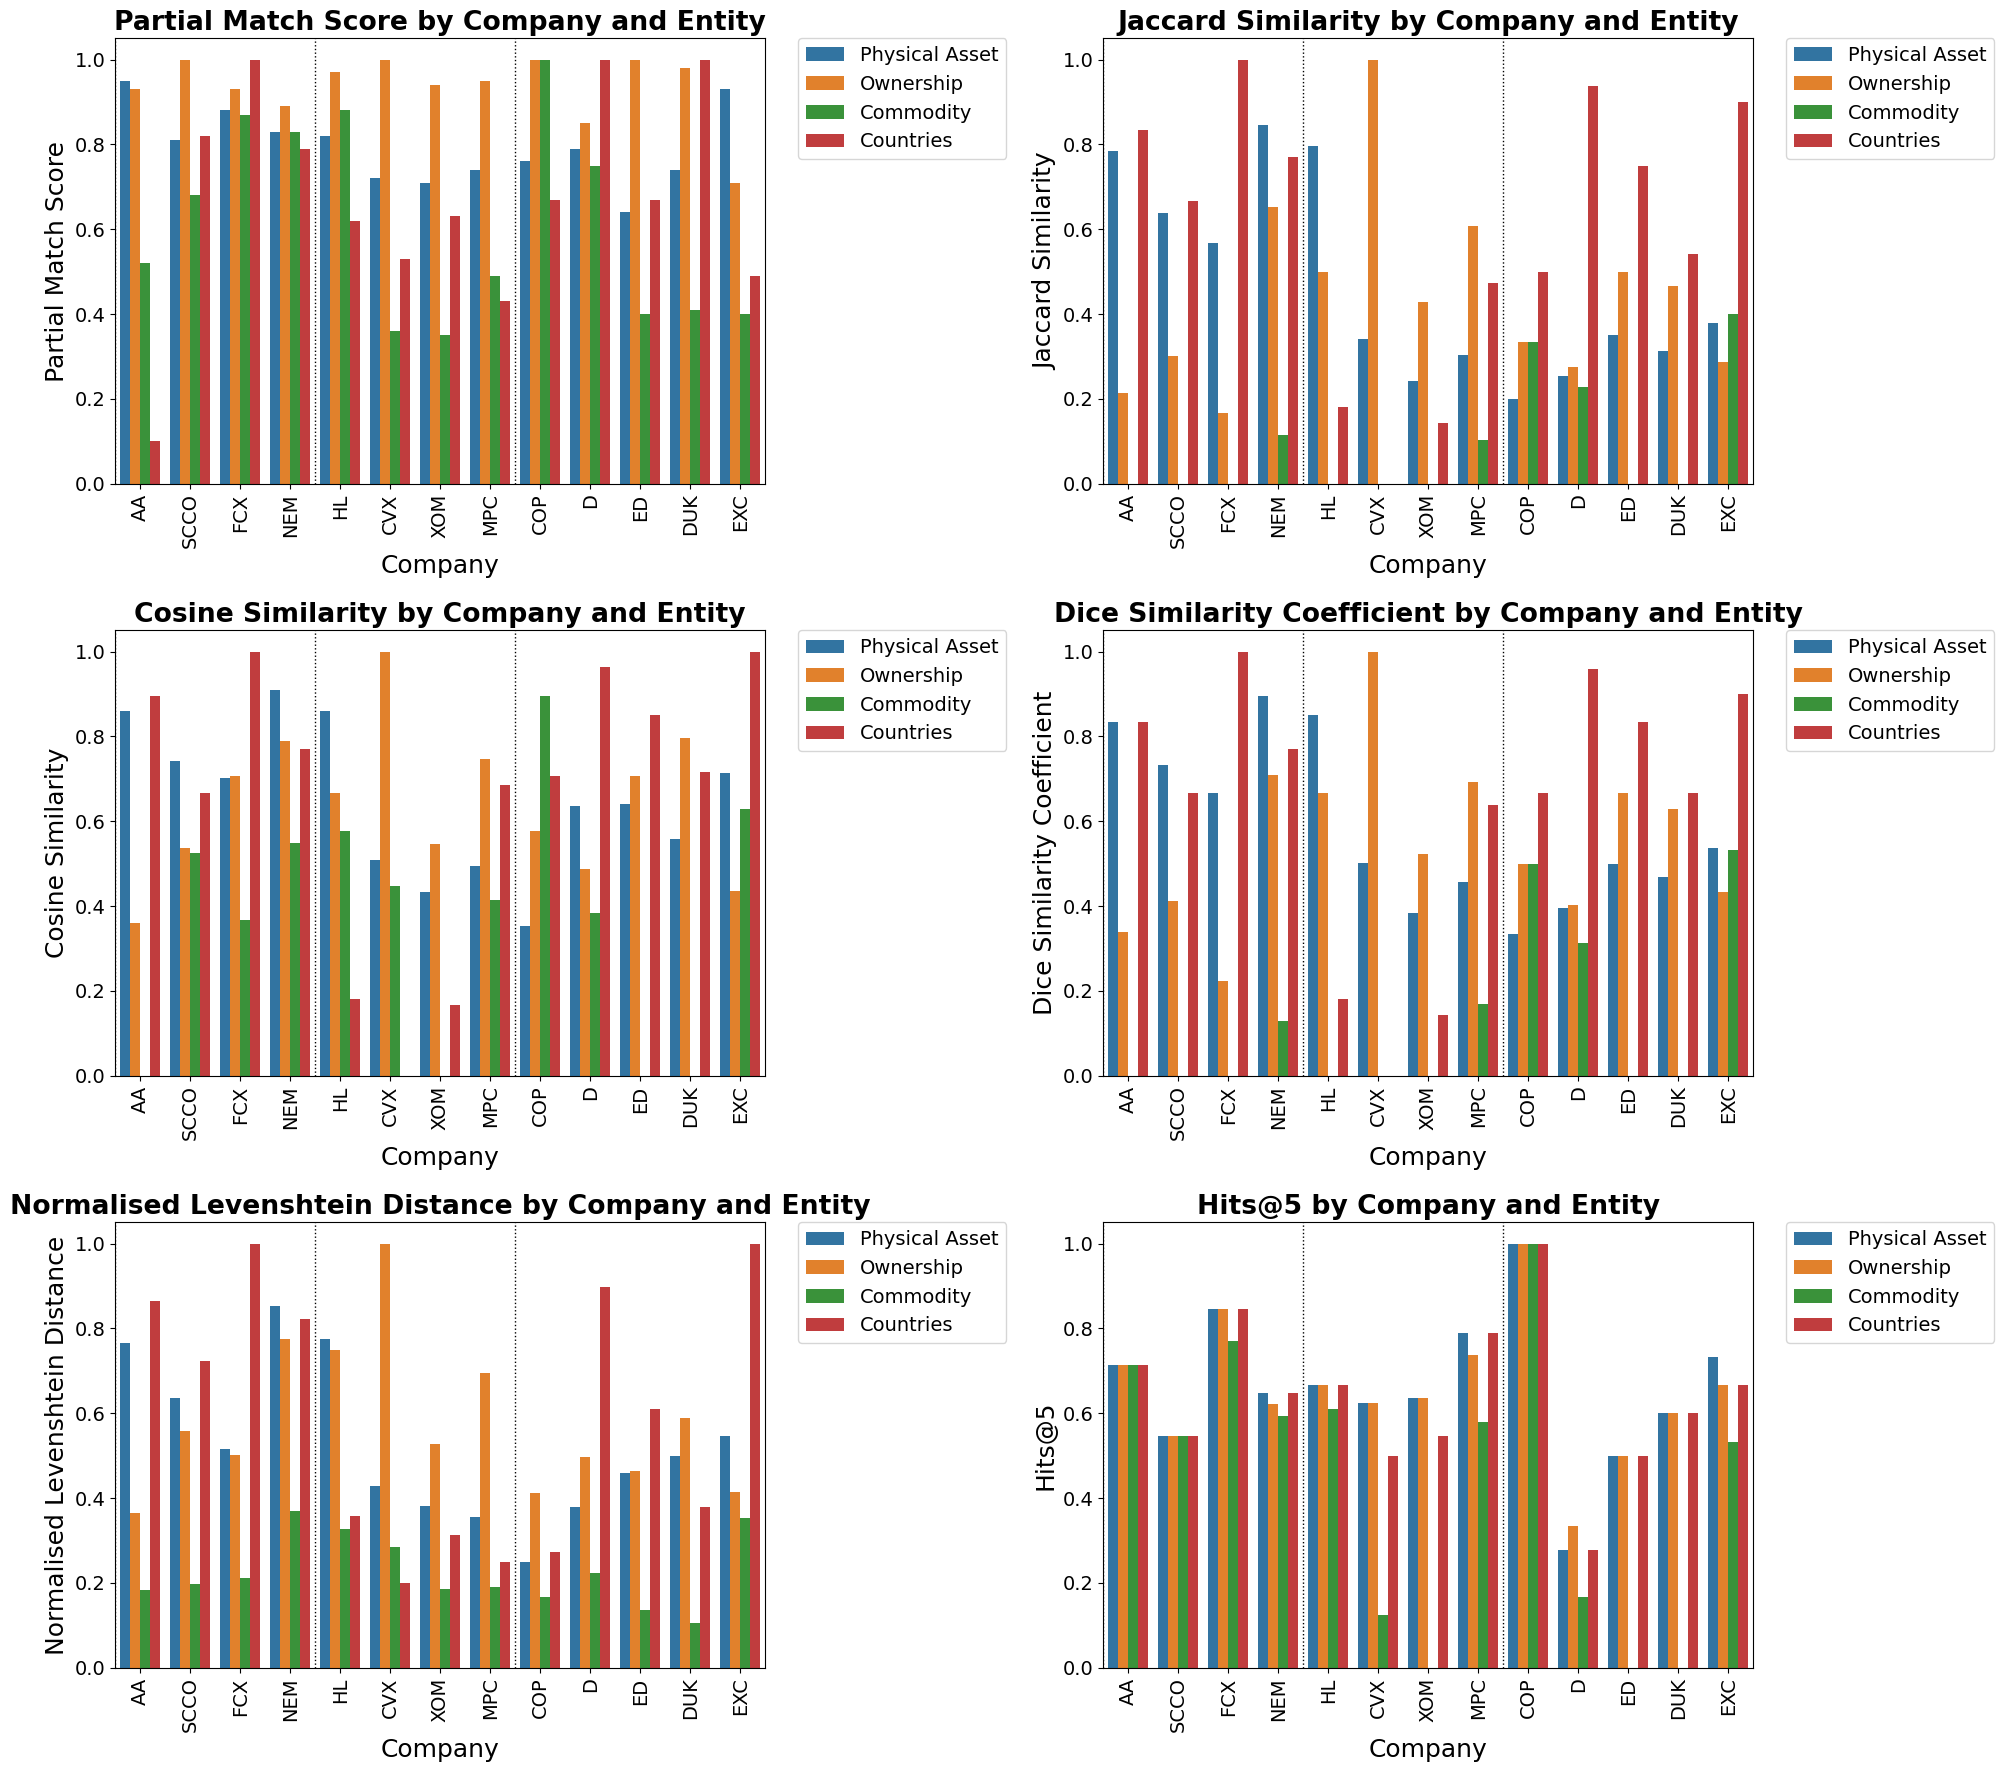

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DataFrame construction based on data
data = {
    'Sector': ['Mining']*20 + ['Oil & Gas']*16 + ['Utilities']*16,
    'Company': ['AA', 'AA', 'AA', 'AA', 'SCCO', 'SCCO', 'SCCO', 'SCCO', 'FCX', 'FCX', 'FCX', 'FCX', 'NEM', 'NEM', 'NEM', 'NEM', 'HL', 'HL', 'HL', 'HL',
               'CVX', 'CVX', 'CVX', 'CVX', 'XOM', 'XOM', 'XOM', 'XOM', 'MPC', 'MPC', 'MPC', 'MPC', 'COP', 'COP', 'COP', 'COP',
               'D', 'D', 'D', 'D', 'ED', 'ED', 'ED', 'ED', 'DUK', 'DUK', 'DUK', 'DUK', 'EXC', 'EXC', 'EXC', 'EXC'],
    'Entity': ['Physical Asset', 'Ownership', 'Commodity', 'Countries'] * 13,
    'Partial Match Score': [0.95, 0.93, 0.52, 0.1, 0.81, 1.0, 0.68, 0.82, 0.88, 0.93, 0.87, 1.0, 0.83, 0.89, 0.83, 0.79, 0.82, 0.97, 0.88, 0.62,
                            0.72, 1.0, 0.36, 0.53, 0.71, 0.94, 0.35, 0.63, 0.74, 0.95, 0.49, 0.43, 0.76, 1.0, 1.0, 0.67,
                            0.79, 0.85, 0.75, 1.0, 0.64, 1.0, 0.4, 0.67, 0.74, 0.98, 0.41, 1.0, 0.93, 0.71, 0.4, 0.49],
    'Jaccard Similarity': [0.7833, 0.2139, 0.0, 0.8333, 0.6389, 0.3, 0.0, 0.6667, 0.5667, 0.1667, 0.0, 1.0, 0.8462, 0.6520, 0.1154, 0.7692,
                           0.7955, 0.5, 0.0, 0.1818, 0.3417, 1.0, 0.0, 0.0, 0.2418, 0.4286, 0.0, 0.1429, 0.3026, 0.6083, 0.1036, 0.4722,
                           0.2, 0.3333, 0.3333, 0.5, 0.2532, 0.2740, 0.2292, 0.9375, 0.3500, 0.5, 0.0, 0.75, 0.3131, 0.4667, 0.0, 0.5417,
                           0.3778, 0.2867, 0.4, 0.9],
    'Cosine Similarity': [0.8591, 0.3609, 0.0, 0.8963, 0.7416, 0.5375, 0.5244, 0.6667, 0.7014, 0.7063, 0.3668, 1.0, 0.9083, 0.7891, 0.5488, 0.7692,
                          0.8608, 0.6667, 0.5776, 0.1818, 0.5084, 1.0, 0.4472, 0.0, 0.4341, 0.5469, 0.0, 0.1667, 0.4935, 0.7457, 0.4149, 0.6855,
                          0.3536, 0.5774, 0.8944, 0.7071, 0.6368, 0.4884, 0.3836, 0.9634, 0.6400, 0.7071, 0.0, 0.85, 0.5573, 0.7953, 0.0, 0.7155,
                          0.7145, 0.4354, 0.6285, 1.0],
    'Dice Similarity Coefficient': [0.8333, 0.3389, 0.0, 0.8333, 0.7333, 0.4127, 0.0, 0.6667, 0.6672, 0.2222, 0.0, 1.0, 0.8949, 0.7090, 0.1282, 0.7692,
                                    0.8515, 0.6667, 0.0, 0.1818, 0.5016, 1.0, 0.0, 0.0, 0.3840, 0.5238, 0.0, 0.1429, 0.4556, 0.6925, 0.1693, 0.6389,
                                    0.3333, 0.5, 0.5, 0.6667, 0.3961, 0.4015, 0.3125, 0.9583, 0.5, 0.6667, 0.0, 0.8333, 0.4683, 0.6286, 0.0, 0.6667,
                                    0.5367, 0.4333, 0.5333, 0.9],
    'Normalised Levenshtein Distance': [0.7667, 0.3658, 0.1839, 0.8639, 0.6349, 0.5590, 0.1966, 0.7222, 0.5148, 0.5020, 0.2114, 1.0, 0.8531, 0.7747, 0.3698, 0.8225,
                                        0.7738, 0.75, 0.3281, 0.3566, 0.4292, 1.0, 0.2857, 0.2, 0.3808, 0.5276, 0.1852, 0.3127, 0.3552, 0.6947, 0.1907, 0.2493,
                                        0.25, 0.4118, 0.1667, 0.2727, 0.3788, 0.4966, 0.2228, 0.8984, 0.4602, 0.4637, 0.1364, 0.61, 0.5001, 0.5889, 0.1051, 0.3789,
                                        0.5472, 0.4136, 0.3520, 1.0],
    'Hits@5': [0.7143, 0.7143, 0.7143, 0.7143, 0.5455, 0.5455, 0.5455, 0.5455, 0.8462, 0.8462, 0.7692, 0.8462, 0.6486, 0.6216, 0.5946, 0.6486,
               0.6667, 0.6667, 0.6111, 0.6667, 0.6250, 0.6250, 0.1250, 0.5000, 0.6364, 0.6364, 0.0, 0.5455, 0.7895, 0.7368, 0.5789, 0.7895,
               1.0, 1.0, 1.0, 1.0, 0.2778, 0.3333, 0.1667, 0.2778, 0.5, 0.5, 0.0, 0.5, 0.6, 0.6, 0.0, 0.6, 0.7333, 0.6667, 0.5333, 0.6667]
}

df = pd.DataFrame(data)

# Set font sizes globally for the plot
plt.rcParams.update({'font.size': 16,   # General font size
                     'axes.titleweight': 'bold', # Title font weight
                     'axes.labelsize': 18,  # Axes labels
                     'xtick.labelsize': 14, # X tick labels
                     'ytick.labelsize': 14, # Y tick labels
                     'legend.fontsize': 14  # Legend font size
                    })

# Define a list of metrics to plot
metrics = ['Partial Match Score', 'Jaccard Similarity', 'Cosine Similarity',
           'Dice Similarity Coefficient', 'Normalised Levenshtein Distance', 'Hits@5']

# Create a grid of subplots with 2 columns and 3 rows
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Generate a plot for each metric with the legend outside the plot
for i, metric in enumerate(metrics):
    sns.barplot(data=df, x='Company', y=metric, hue='Entity', ax=axes[i])
    axes[i].set_title(f'{metric} by Company and Entity')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)

    # Add dotted vertical lines at the sector boundaries
    sector_boundaries = df.groupby('Sector').ngroup()
    unique_boundaries = sector_boundaries.unique()
    for boundary in unique_boundaries:
        axes[i].axvline(x=boundary * 4 - 0.5, color='black', linestyle=':', linewidth=1)

    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('comparison_metrics_plot.png')  # Save as PNG
plt.show()
